# Classification by Mechanism of Action

## Imports and Loading Data

In [ ]:
# IMPORTS
# base
import pandas as pd
import numpy as np
from typing import Literal

# importing from scripts
from src.scripts import targets
from src.scripts import cheng_prusoff_classification as cp

# stats
import statsmodels.formula.api as smf

# plots
import seaborn as sns
from matplotlib import pyplot as plt

# remove warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# select for cheng prusoff
usecols = [
    "Ki (nM)",
    "IC50 (nM)",
]

# load data
df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

# clean data
df.replace(" NV,", np.nan, inplace=True)
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(" C", "")
    df[col] = (
        df[col].astype(str).str.replace(">", "").str.replace("<", "").astype(float)
    )

## Classification Functions
The analytical derivation of these functions will soon be available...

## Initial Data with No Classification

In [4]:
# prepare data for cheng-prusoff
both_log = cp.cheng_prusoff_data(df)

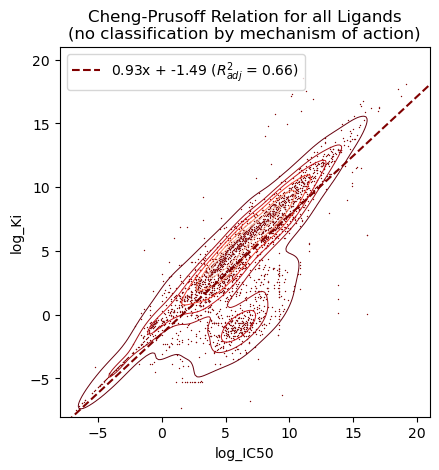

In [5]:
# model with no classification by mechanism of action
res = cp.cheng_prusoff_model(both_log)
fig, ax = plt.subplots(1, 1)
cp.cheng_prusoff_plot([both_log], [res], ax=ax)
ax.set_xlim(-8, 21)
ax.set_ylim(ax.get_xlim())
ax.set_aspect("equal", adjustable="box")
ax.set_title(
    "Cheng-Prusoff Relation for all Ligands\n(no classification by mechanism of action)"
)
ax.legend()
plt.show()

## Classification by Gaussian Mixture Models

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler().set_output(transform="pandas")
both_log_norm = ssc.fit_transform(both_log)
gmf = GaussianMixture(n_components=2, random_state=11)
both_log_norm["GMM"] = gmf.fit_predict(both_log_norm)

## seperate outliers from cluster
cluster_two = both_log_norm.query("GMM == 0")

gm2 = GaussianMixture(n_components=2, random_state=11)
cluster_two["GMM2"] = gm2.fit_predict(cluster_two)
cluster_two["GMM2"] -= 1


final = pd.concat([both_log_norm, cluster_two], axis=0).fillna(0)
final["cluster"] = final["GMM"] + final["GMM2"] + 1
final.drop(columns=["GMM", "GMM2"], inplace=True)

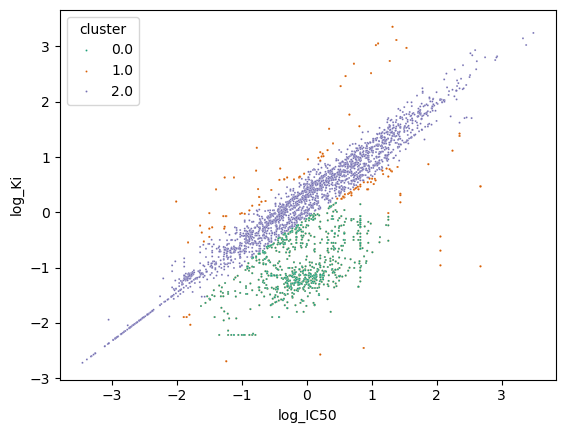

In [7]:
fig, axs = plt.subplots(1, 1)
sns.scatterplot(
    final,
    x="log_IC50",
    y="log_Ki",
    hue="cluster",
    s=2,
    ax=axs,
    palette="Dark2",
)
# lgnd = plt.legend(title='Cluster', loc='upper left', labels=['Non-comp', 'Comp', 'Outlier'])
plt.show()

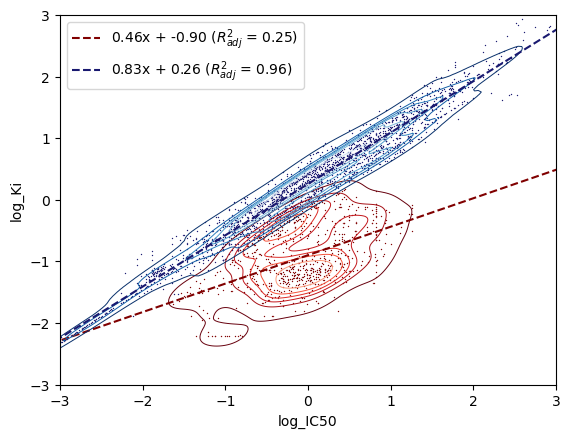

In [8]:
fam1 = final.query("cluster == 0")
fam2 = final.query("cluster == 2")
fam_out = final.query("cluster == 1")
fams = [fam1, fam2]

reg1 = cp.cheng_prusoff_model(fam1)
reg2 = cp.cheng_prusoff_model(fam2)
regs = [reg1, reg2]

fig, ax = plt.subplots(1, 1)
cp.cheng_prusoff_plot(fams, regs, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(ax.get_xlim())
plt.legend()
plt.show()

## Biochemically-informed Classification

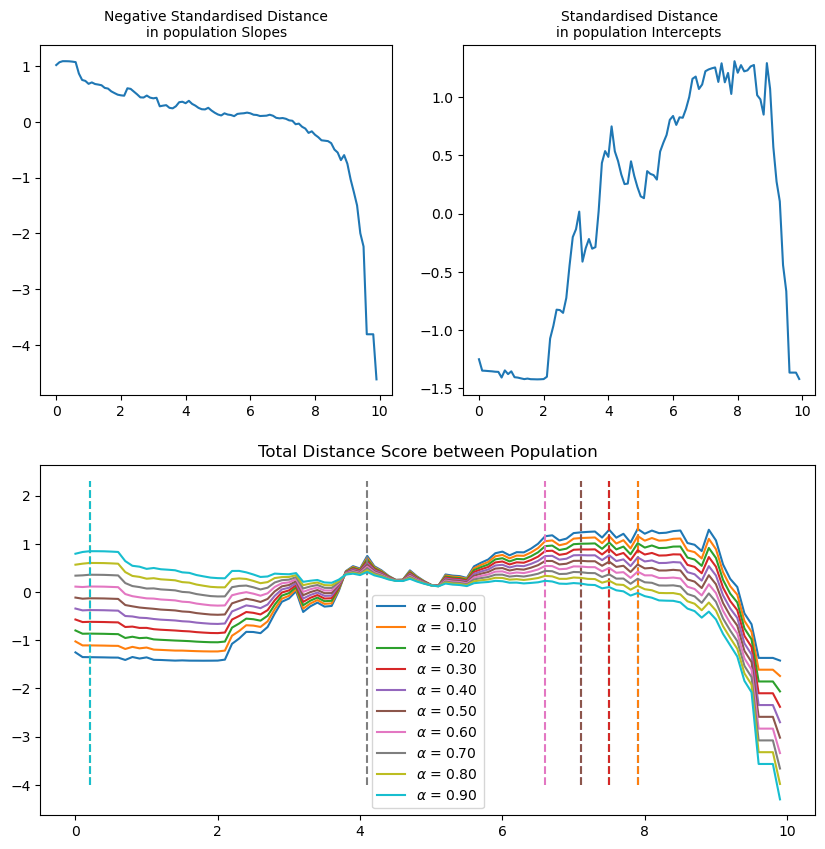

In [9]:
b_max = cp.cheng_prusoff_classifier(
    df=both_log, min_seperator_interecpt=0, show_evaluation=True
)

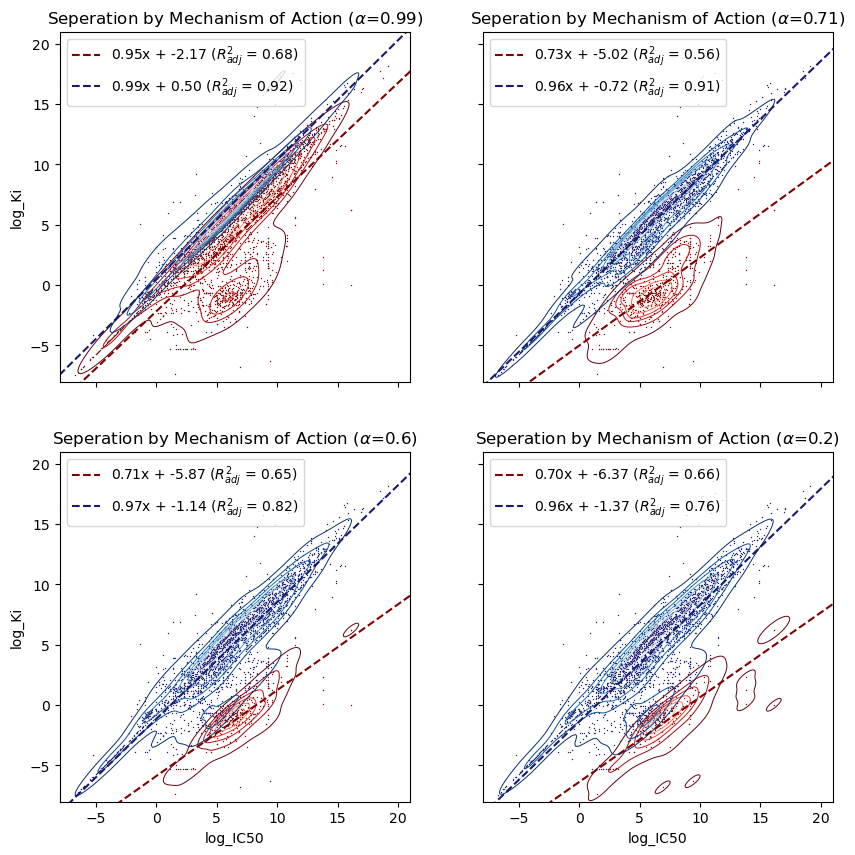

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for alpha, ax in zip([0.99, 0.71, 0.6, 0.2], axs.flat):
    # results with optimal seperator
    m = 1
    b = b_max[alpha]

    # assign labels with optimal seperator intercept; cluster 1 = below line
    both_log["label"] = (both_log["log_IC50"] < m * both_log["log_Ki"] + b).astype(int)
    fam0 = both_log.query("label == 0")
    fam1 = both_log.query("label == 1")

    # model per cluster
    res0 = cp.cheng_prusoff_model(fam0)
    res1 = cp.cheng_prusoff_model(fam1)
    cp.cheng_prusoff_plot([fam0, fam1], [res0, res1], ax=ax)
    ax.set_xlim(-8, 21)
    ax.set_ylim(ax.get_xlim())
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(rf"Seperation by Mechanism of Action ($\alpha$={alpha})")
    ax.legend()
plt.show()

## Further Analysis of Optimally Classified Data
The optimal mechanism of action is obtained through the biochemically-informed classifier described above, with an $\alpha$ parameter set to $\alpha$=0.71.

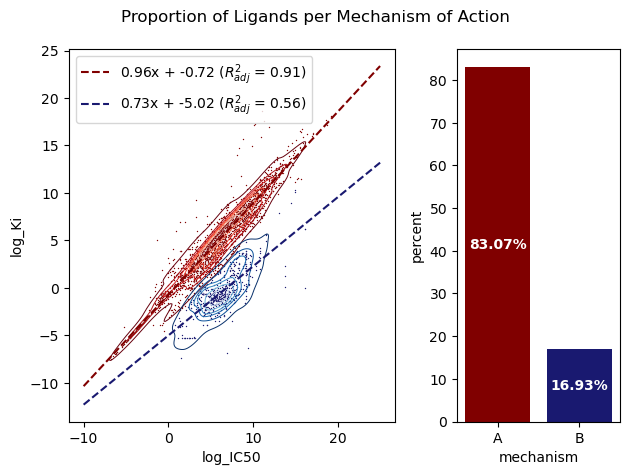

In [11]:
# assign labels with optimal seperator intercept; cluster 1 = below line
alpha = 0.71  # as found above
b = b_max[alpha]
classified_action = both_log.copy().drop(columns=["label"])
classified_action["mechanism"] = (both_log["log_IC50"] < both_log["log_Ki"] + b).astype(
    int
)
classified_action["mechanism"] = classified_action["mechanism"].replace(
    {1: "A", 0: "B"}
)
fam0 = classified_action.query("mechanism == 'A'")
fam1 = classified_action.query("mechanism == 'B'")

res0 = cp.cheng_prusoff_model(fam0)
res1 = cp.cheng_prusoff_model(fam1)

fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]})

cp.cheng_prusoff_plot([fam0, fam1], [res0, res1], ax=axs[0])
axs[0].legend()

sns.countplot(classified_action, x="mechanism", ax=axs[1], stat="percent")

colors = ["maroon", "midnightblue"]
for bar, color in zip(axs[1].patches, colors):
    bar.set_facecolor(color)
    count = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    y = count / 2
    axs[1].text(
        x,
        y,
        f"{count:.2f}%",
        ha="center",
        va="center",
        fontweight="bold",
        color="white",
    )
fig.suptitle("Proportion of Ligands per Mechanism of Action")
plt.tight_layout()
plt.show()

In [12]:
lig_cols = [
    "ChEMBL ID of Ligand",
    "ZINC ID of Ligand",
    "Article DOI",
]

In [13]:
# is the classification correct?
ligands = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=lig_cols,
)

In [14]:
classified_ligands = pd.merge(
    left=classified_action, right=ligands, left_index=True, right_index=True
)
rd_X = classified_ligands[classified_ligands["ChEMBL ID of Ligand"].notna()]
rd_A = classified_ligands[classified_ligands["ChEMBL ID of Ligand"].notna()].query(
    "mechanism=='A'"
)
rd_B = classified_ligands[classified_ligands["ChEMBL ID of Ligand"].notna()].query(
    "mechanism=='B'"
)


display(rd_A.sample(n=5, random_state=11))
display(rd_B.sample(n=5, random_state=111))

log_IC50     log_Ki mechanism                Article DOI  \
170373   6.802395   8.433812         A     10.1002/cbic.200900108   
221377   4.990433   4.225373         A                        NaN   
16652    4.094345   1.916923         A          10.1021/jm960047o   
424690   9.952278   9.903987         A                        NaN   
404098  11.112448  10.966473         A  10.3109/14756360903489581   

       ChEMBL ID of Ligand ZINC ID of Ligand  
170373        CHEMBL199829      ZINC28564770  
221377       CHEMBL1762570      ZINC71318229  
16652          CHEMBL71715      ZINC34266378  
424690        CHEMBL260876      ZINC08437745  
404098           CHEMBL599      ZINC13129998

log_IC50    log_Ki mechanism           Article DOI  \
220427   4.762174 -2.603690         B                   NaN   
33476   11.512925  5.645447         B        10.1038/nsb921   
33463    7.590852  0.173953         B  10.1128/AAC.00448-06   
33445    7.774856 -0.261365         B  10.1128/AAC.00448-06   
767      1.386294 -3.473768         B     10.1021/jm990336n   

       ChEMBL ID of Ligand ZINC ID of Ligand  
220427       CHEMBL1288000      ZINC64559146  
33476             CHEMBL36      ZINC00057464  
33463          CHEMBL22039      ZINC13472728  
33445          CHEMBL21921      ZINC13472730  
767            CHEMBL13134      ZINC03936474

In [15]:
bool((rd_X["ChEMBL ID of Ligand"] == "CHEMBL1664").sum())

False

[1.00000000e+04 2.15443469e+06 4.64158883e+08 1.00000000e+11]


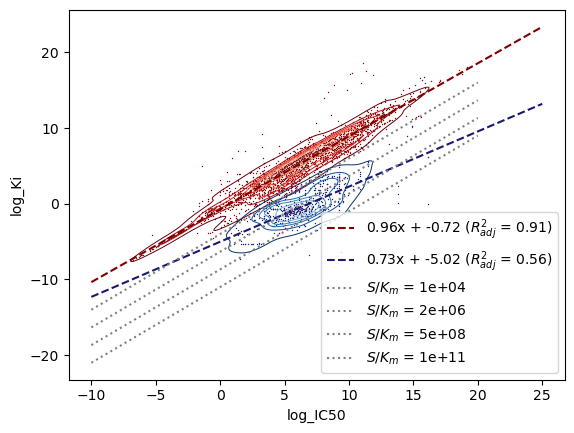

In [16]:
def get_chembl_coords(df, chemblid):
    line = df[df["ChEMBL ID of Ligand"] == chemblid]
    log_ic50 = line["log_IC50"].to_numpy()  # X
    log_ki = line["log_Ki"].to_numpy()  # Y
    return log_ic50, log_ki


def plot_chembl_on_cp(df, chemblid, color="green", ax=None, label=True):
    x, y = get_chembl_coords(df, chemblid)
    if label:
        ax.plot(x, y, "ro", fillstyle="none", markersize=4, color=color, label=chemblid)
    else:
        ax.plot(x, y, "ro", fillstyle="none", markersize=2, alpha=0.2, color=color)


fig, ax = plt.subplots(1, 1)
cp.cheng_prusoff_plot([fam0, fam1], [res0, res1], ax=ax)
# for chembi in rd_X["ChEMBL ID of Ligand"]:
#     plot_chembl_on_cp(rd_X,chembi,color="red",ax=ax, label=False)
# plot_chembl_on_cp(rd_X,"CHEMBL116",color="green",ax=ax)
# plot_chembl_on_cp(rd_X,"CHEMBL36",color="yellow",ax=ax)
# plot_chembl_on_cp(rd_X,"CHEMBL599",color="blue",ax=ax)
# plot_chembl_on_cp(rd_X,"CHEMBL116",color="brown",ax=ax)
# plot_chembl_on_cp(rd_X,"CHEMBL260876",color="orange",ax=ax)
# plot_chembl_on_cp(rd_X,"CHEMBL3627587",color="red",ax=ax)

skm_ratio = np.logspace(4, 11, num=4, base=10)
print(skm_ratio)
for skmr in skm_ratio:
    ax.plot(
        [-10, 20],
        np.array([-10, 20]) - np.log10(skmr),
        label=f"$S/K_m$ = {skmr:.0e}",
        color="gray",
        linestyle=":",
    )
ax.legend()
plt.show()

CHEMBL599(mech. A): "oxicams bind to the active site of COX-2" (10.1074/jbc.M113.517987) --> competitive

CHEMBL36 (mech B.): "Pyr binds at the active site of PvDHFR" --> comp fuck (PMID: 16135570)


Might be a banger explanation of observations, to be confirmed with timeseries:

"While competitive binding dominates, there is growing interest in allosteric modulators, which may bind uncompetitively or non-competitively."

DONE: h-index/metrics per mechanism

TODO: timeseries of mechanisms

(this is added in success per molecular features, as binding mechanisms are directly linked to molecular mechanisms)

### H-index and Average Citations per mechanism

In [17]:
dois = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=["Article DOI"],
)

In [18]:
# prepare data
import json

with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations = pd.DataFrame(citations)
classified_dois = pd.merge(
    left=classified_action, right=dois, left_index=True, right_index=True
)
classified_citations = pd.merge(
    left=classified_dois,
    right=citations,
    left_on="Article DOI",
    right_on="doi",
    how="inner",
)  # note: around half the mechanisms are lost because don't have publication
# classified_citations["mechanism"].value_counts()/classified_citations["mechanism"].shape[0] #but proportion remains similar (89%-11%) --> ok for further analysis
classified_citations.drop(
    columns=["log_IC50", "log_Ki", "Article DOI", "doi"], inplace=True
)

In [19]:
# calculate h-index and avg citations
h_per_mech = cp.classified_h_index(classified_citations)
avg_cit_per_mech = (
    classified_citations.groupby("mechanism").sum()
    / classified_citations.groupby("mechanism").count()
).to_dict()["citation"]

In [145]:
classified_citations

mechanism  citation
0            A      39.0
1            A      39.0
2            A      39.0
3            B      26.0
4            B      26.0
...        ...       ...
1462         A      94.0
1463         A      94.0
1464         A      94.0
1465         A      22.0
1466         A      22.0

[1467 rows x 2 columns]

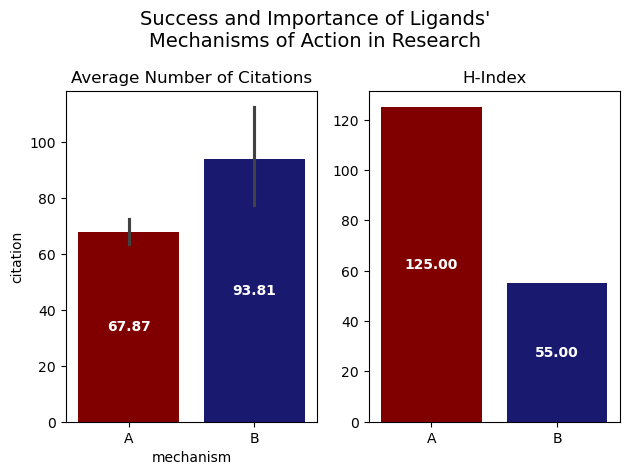

In [146]:
# plot results
fig, axs = plt.subplots(1, 2)

sns.barplot(classified_citations, x="mechanism", y="citation", ax=axs[0])
axs[0].set_title("Average Number of Citations")
sns.barplot(h_per_mech, ax=axs[1])
axs[1].set_title("H-Index")


colors = ["maroon", "midnightblue"]
for ax in axs:
    for bar, color in zip(ax.patches, colors):
        bar.set_facecolor(color)
        count = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        y = count / 2
        ax.text(
            x,
            y,
            f"{count:.2f}",
            ha="center",
            va="center",
            fontweight="bold",
            color="white",
        )
fig.suptitle(
    "Success and Importance of Ligands'\nMechanisms of Action in Research", fontsize=14
)
plt.tight_layout()
plt.show()

### Lipinski's rule

In [21]:
from src.scripts.smiles import lipinski

In [22]:
mol_df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=["Ligand SMILES"],
)

In [23]:
classified_lipinski = pd.merge(
    left=classified_action, right=mol_df, left_index=True, right_index=True
)
classified_lipinski["Lipinski"] = classified_lipinski["Ligand SMILES"].apply(lipinski)

[15:11:39] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[15:11:40] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


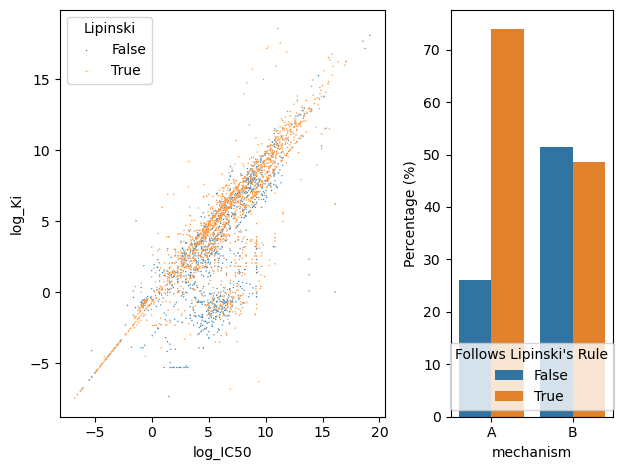

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]})
# cp.cheng_prusoff_plot()
sns.scatterplot(
    classified_lipinski, x="log_IC50", y="log_Ki", hue="Lipinski", s=1, ax=ax0
)
x, y = "mechanism", "Lipinski"
df1 = classified_lipinski.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename("percent").reset_index()
sns.barplot(data=df1, x="mechanism", y="percent", hue="Lipinski", ax=ax1)
ax1.set_ylabel("Percentage (%)")
ax1.legend(title="Follows Lipinski's Rule", loc="lower center")
# sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

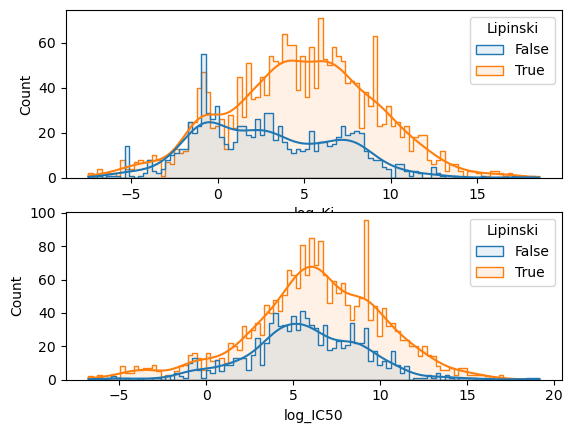

In [25]:
fig, axs = plt.subplots(2, 1)
sns.histplot(
    classified_lipinski,
    x="log_Ki",
    hue="Lipinski",
    kde=True,
    element="step",
    bins=100,
    alpha=0.1,
    ax=axs[0],
)
sns.histplot(
    classified_lipinski,
    x="log_IC50",
    hue="Lipinski",
    kde=True,
    element="step",
    bins=100,
    alpha=0.1,
    ax=axs[1],
)
plt.show()
# classified_action

In [ ]:
classified_lipinski_true = classified_lipinski.query("Lipinski == True")
classified_lipinski_false = classified_lipinski.query("Lipinski == False")

ki_counts_true = (
    classified_lipinski_true["log_Ki"].value_counts(bins=100)
    / classified_lipinski_true["log_Ki"].value_counts(bins=100).mean()
)
ki_counts_false = (
    classified_lipinski_false["log_Ki"].value_counts(bins=100)
    / classified_lipinski_false["log_Ki"].value_counts(bins=100).mean()
)

(-0.722, -0.467]    6.107660
(2.078, 2.332]      3.209110
(2.587, 2.841]      3.105590
(-0.213, 0.042]     2.898551
(-0.976, -0.722]    2.795031
                      ...   
(13.021, 13.276]    0.000000
(-5.557, -5.303]    0.000000
(12.003, 12.258]    0.000000
(-4.794, -4.539]    0.000000
(14.548, 14.803]    0.000000
Name: count, Length: 100, dtype: float64

T-test Results:
	- Statistic: t=4.182916580064959
	- P-value: p=2.994e-05


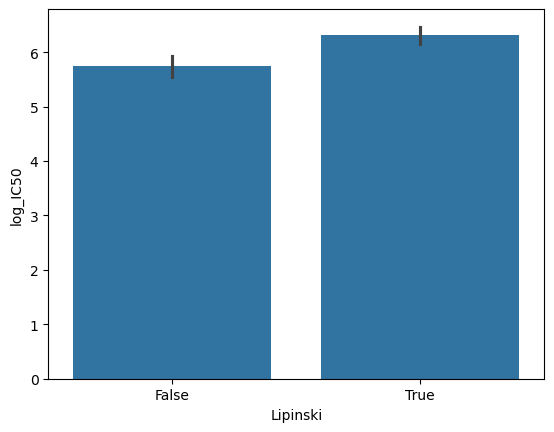

In [66]:
from scipy.stats import ttest_ind

sns.barplot(classified_lipinski, x="Lipinski", y="log_IC50")
t_test = ttest_ind(
    a=classified_lipinski.query("Lipinski==True")["log_IC50"],
    b=classified_lipinski.query("Lipinski==False")["log_IC50"],
    equal_var=False,
)
print(
    f"T-test Results:\n\t- Statistic: t={t_test.statistic}\n\t- P-value: p={t_test.pvalue:.3e}"
)

##### with citations

In [ ]:
usecols = ["Ki (nM)", "IC50 (nM)", "Ligand SMILES", "Article DOI"]

# load data
entire = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

In [105]:
# clean data
entire.replace(" NV,", np.nan, inplace=True)
for col in ["Ki (nM)", "IC50 (nM)"]:
    entire[col] = entire[col].astype(str).str.replace(" C", "")
    entire[col] = (
        entire[col].astype(str).str.replace(">", "").str.replace("<", "").astype(float)
    )

In [108]:
# merge
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations = pd.DataFrame(citations)
lipinski_doi = pd.merge(
    left=entire, right=citations, left_on="Article DOI", right_on="doi"
).drop(columns=["Article DOI"])

In [ ]:
# approx 35 mins to run
lipinski_doi.dropna(subset=["citation"], inplace=True)
lipinski_doi["lipinski"] = lipinski_doi["Ligand SMILES"].apply(lipinski)

[10:23:34] Explicit valence for atom # 12 N, 4, is greater than permitted
[10:23:34] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[10:24:27] Explicit valence for atom # 17 O, 3, is greater than permitted
[10:24:27] Explicit valence for atom # 16 O, 3, is greater than permitted
[10:24:27] Explicit valence for atom # 16 O, 3, is greater than permitted
[10:24:27] Explicit valence for atom # 17 O, 3, is greater than permitted
[10:24:27] Explicit valence for atom # 16 O, 3, is greater than permitted
[10:24:27] Explicit valence for atom # 16 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[10:25:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[10:25:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16
[10:25:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[10:25:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[10:25:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[10:25:27] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 17 18 19 30 31 32
[10:25:27] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 16 17 18 28 29 30
[10:25:27] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 16 17 18 29 30 31


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[10:25:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[10:25:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[10:25:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[10:25:44] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15


Invalid SMILES string.


[10:26:02] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


Invalid SMILES string.


[10:28:50] Explicit valence for atom # 1 B, 6, is greater than permitted
[10:28:50] Explicit valence for atom # 1 B, 6, is greater than permitted
[10:28:50] Explicit valence for atom # 1 C, 7, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[10:29:02] Explicit valence for atom # 19 C, 6, is greater than permitted
[10:29:02] Explicit valence for atom # 4 C, 6, is greater than permitted
[10:29:02] Explicit valence for atom # 8 C, 6, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[10:31:18] Explicit valence for atom # 7 B, 6, is greater than permitted
[10:31:18] Explicit valence for atom # 7 B, 6, is greater than permitted
[10:31:18] Explicit valence for atom # 7 B, 6, is greater than permitted
[10:31:18] Explicit valence for atom # 7 C, 6, is greater than permitted
[10:31:18] Explicit valence for atom # 7 B, 6, is greater than permitted
[10:31:18] Explicit valence for atom # 7 B, 6, is greater than permitted
[10:31:18] Explicit valence for atom # 7 C, 6, is greater than permitted
[10:31:18] Explicit valence for atom # 7 C, 6, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[10:48:02] Explicit valence for atom # 11 C, 6, is greater than permitted


Invalid SMILES string.


[10:58:54] Explicit valence for atom # 22 H, 3, is greater than permitted


Invalid SMILES string.


<Axes: xlabel='lipinski', ylabel='citation'>

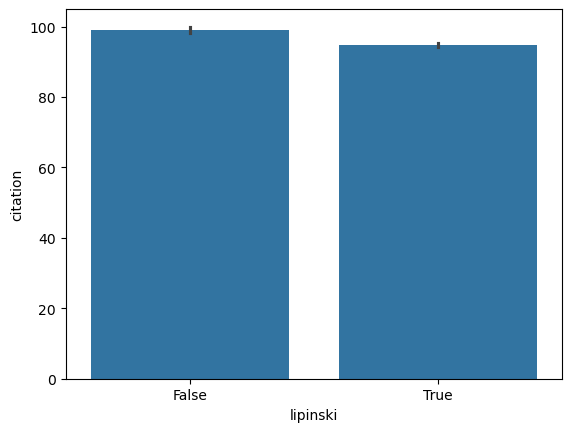

In [121]:
sns.barplot(lipinski_doi, x="lipinski", y="citation")

In [124]:
lipinski_diff_in_mean = (
    lipinski_doi.query("lipinski==False")["citation"].mean()
    - lipinski_doi.query("lipinski==True")["citation"].mean()
)
t_test = ttest_ind(
    a=lipinski_doi.query("lipinski==True")["citation"],
    b=lipinski_doi.query("lipinski==False")["citation"],
    equal_var=False,
)
print(f"Difference in mean citations: {lipinski_diff_in_mean:.3f}")
print(
    f"T-test Results:\n\t- Statistic: t={t_test.statistic}\n\t- P-value: p={t_test.pvalue:.3e}"
)

Difference in mean citations: 4.399
T-test Results:
	- Statistic: t=-8.30195605301632
	- P-value: p=1.025e-16


#### with patents

In [140]:
# patents from bindingDB
usecols = [
    "Ligand SMILES",
    "Patent Number",
]

lipinski_pat = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

# patent count data previously collected
with open("../src/data/patents.json", "r") as f:
    patents = json.load(f)
patents_df = pd.DataFrame(
    [
        {
            "patent": patent["patent"],
            "title": patent["info"].get("title", np.nan),
            "abstract": (patent["info"].get("abstract", "") or "").strip(),
            "url": patent["info"].get("url", np.nan),
            "status": patent["info"].get("status", np.nan),
            "families citing": int(patent["info"].get("families citing", 0) or 0),
            "cited by": int(patent["info"].get("cited by", 0) or 0),
        }
        for patent in patents
        if isinstance(patent, dict) and isinstance(patent.get("info"), dict)
    ]
)
patents_df["total citations"] = patents_df["families citing"] + patents_df["cited by"]
patents_df.drop(
    columns=["url", "abstract", "status", "families citing", "cited by"], inplace=True
)

# merge both dataset
lipinski_pat = pd.merge(
    left=lipinski_pat, right=patents_df, left_on="Patent Number", right_on="patent"
).drop(columns=["Patent Number"])

In [141]:
# approx 35 mins to run
lipinski_pat.dropna(subset=["total citations"], inplace=True)
lipinski_pat["lipinski"] = lipinski_pat["Ligand SMILES"].apply(lipinski)

[12:26:00] non-ring atom 28 marked aromatic
[12:26:00] non-ring atom 28 marked aromatic
[12:26:00] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:26:01] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:01] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:26:09] Explicit valence for atom # 3 C, 5, is greater than permitted


Invalid SMILES string.


[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 29 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 29 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 29 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 29 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 29 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:26:21] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:26:23] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:26:23] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:26:35] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[12:26:36] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[12:26:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[12:26:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[12:26:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[12:26:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[12:26:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:26:41] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.


[12:26:42] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.


[12:26:44] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:26:44] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:26:44] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:26:53] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:26:53] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:26:54] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 34 35 36
[12:26:54] Can't

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:27:02] Explicit valence for atom # 66 N, 4, is greater than permitted
[12:27:02] Explicit valence for atom # 64 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:27:09] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:27:09] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:27:13] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 35 36 37 38 39
[12:27:13] Can't kekulize mol.  Unkekulized atoms: 29 30 31 33 34
[12:27:13] Can't kekulize mol.  Unkekulized atoms: 29 30 31 33 34


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:27:15] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[12:27:15] Can't kekulize mol.  Unkekulized atoms: 20 21 22


Invalid SMILES string.
Invalid SMILES string.


[12:27:21] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:27:21] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:27:21] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:27:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[12:27:29] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:27:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[12:27:29] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:27:31] Can't kekulize mol.  Unkekulized atoms: 3 18 19 20 21 22 23


Invalid SMILES string.


[12:27:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:27:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:27:34] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:27:34] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:27:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 10 12


Invalid SMILES string.


[12:27:40] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21


Invalid SMILES string.


[12:27:44] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[12:27:59] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[12:27:59] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:27:59] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:28:02] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 36
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 39
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 22 23 25
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[12:28:02] Can

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 39
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 22 23 25
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:02] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
[12:28:02] Can

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:28:04] Explicit valence for atom # 27 N, 4, is greater than permitted
[12:28:04] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:28:04] Explicit valence for atom # 27 N, 4, is greater than permitted
[12:28:04] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 27 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 27 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom # 33 N, 4, is greater than permitted
[12:28:05] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:28:07] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14
[12:28:07] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14
[12:28:07] Can't kekulize mol.  Unkekulized atoms: 16 17 18 20 21 23 24
[12:28:07] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18 20 21


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:28:20] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[12:28:20] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.


[12:28:22] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:28:24] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19


Invalid SMILES string.


[12:28:27] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:28:28] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:28:28] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:28:31] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:31]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:28:31] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
[12:28:31] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:28:31] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[12:28:34] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[12:28:34] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[12:28:34] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[12:28:34] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[12:28:34] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[12:28:34] Explicit valence for atom # 3 N

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:28:36] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:28:37] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[12:28:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 11 13 14 15 16
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 20
[12:28:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 21
[12:28:38] Can't kekulize mol. 

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:28:41] Can't kekulize mol.  Unkekulized atoms: 7 8 15 16 17


Invalid SMILES string.


[12:28:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25


Invalid SMILES string.


[12:28:42] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 18 20
[12:28:42] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 17 19
[12:28:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 8 9
[12:28:42] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 19 20 21
[12:28:42] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 17 18
[12:28:42] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:28:42] Can't kekulize mol.  Unkekulized atoms: 15 16 17 31 32 34 35 36 37


Invalid SMILES string.


[12:28:44] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:28:44] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:28:44] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:28:45] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:28:45] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:28:45] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:28:45] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:28:46] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:28:50] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.


[12:28:55] Explicit valence for atom # 32 N, 4, is greater than permitted


Invalid SMILES string.


[12:28:57] Can't kekulize mol.  Unkekulized atoms: 18 20 21 22 23
[12:28:57] Can't kekulize mol.  Unkekulized atoms: 13 15 16 17 18
[12:28:57] Can't kekulize mol.  Unkekulized atoms: 15 17 18 19 20
[12:28:57] Can't kekulize mol.  Unkekulized atoms: 22 24 25 26 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:29:17] Explicit valence for atom # 9 N, 4, is greater than permitted
[12:29:17] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:29:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21 22 23 24 25
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 18 19 20 21 22 23
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:29:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
[12:29:23] Can't kekulize mol.  Unk

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:29:24] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:29:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[12:29:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[12:29:24] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:29:24] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:29:27] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:29:27] Explicit valence for atom # 9 N, 4, is greater than permitted
[12:29:27] Explicit valence for atom # 9 N, 4, is greater than permitted
[12:29:27] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:29:27] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:29:32] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 33


Invalid SMILES string.


[12:29:34] Explicit valence for atom # 18 N, 4, is greater than permitted


Invalid SMILES string.


[12:29:41] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[12:29:52] Explicit valence for atom # 16 N, 5, is greater than permitted


Invalid SMILES string.


[12:29:56] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 14


Invalid SMILES string.


[12:29:57] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 23 24
[12:29:57] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20


Invalid SMILES string.
Invalid SMILES string.


[12:29:58] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:29:58] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:30:01] Explicit valence for atom # 49 N, 4, is greater than permitted
[12:30:01] Explicit valence for atom # 49 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:30:05] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21
[12:30:05] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21


Invalid SMILES string.
Invalid SMILES string.


[12:30:06] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 38 39 40
[12:30:06] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 38 39 40


Invalid SMILES string.
Invalid SMILES string.


[12:30:18] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:30:18] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:30:18] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:30:18] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:30:18] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:30:18] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[12:30:20] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[12:30:33] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31


Invalid SMILES string.


[12:30:39] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[12:30:46] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 19


Invalid SMILES string.


[12:30:55] Can't kekulize mol.  Unkekulized atoms: 23 24 25
[12:30:55] Can't kekulize mol.  Unkekulized atoms: 29 30 31


Invalid SMILES string.
Invalid SMILES string.


[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 8 9 10 19 20
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:30:57] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 9 10 11 20 21
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:30:57] Can't kekulize mol.  Unkekuliz

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:00] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:31:00] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:31:00] Can't kekulize mol.  Unk

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:31:03] Can't kekulize mol.  Unkekulized atoms: 14 15 16


Invalid SMILES string.


[12:31:04] Can't kekulize mol.  Unkekulized atoms: 23 25 26
[12:31:04] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[12:31:04] Can't kekulize mol.  Unkekulized atoms: 7 8 9


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 8 9 11 12 13
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 8 9 11 12 13
[12:31:05] Can't kekulize mol.  Unkekulized atoms: 8 9 11 12 13
[12:31:05] Can't

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:06] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


Invalid SMILES string.


[12:31:06] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 22
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 22
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[12:31:06] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:08] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:31:08] Can't kekulize mol.  Unkekulized atoms: 2 3 19 21 22
[12:31:08] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:31:08] Can't kekulize mol.  Unkekulized atoms: 2 3 19 21 22


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Invalid SMILES string.


[12:31:17] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[12:31:24] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:31:24] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:31:25] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:31:25] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:31:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:31:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:31:33] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:31:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:31:33] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:31:35] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 11 12 14
[12:31:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:38] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:31:38] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:31:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 27


Invalid SMILES string.


[12:31:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14


Invalid SMILES string.


[12:31:48] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:31:48] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:31:49] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 24
[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 24
[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24
[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
[12:31:50] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:31:52] Explicit valence for atom # 41 N, 4, is greater than permitted


Invalid SMILES string.


[12:32:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:32:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:32:09] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:32:11] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:32:15] Explicit valence for atom # 41 N, 4, is greater than permitted
[12:32:15] Explicit valence for atom # 41 N, 4, is greater than permitted
[12:32:15] Explicit valence for atom # 41 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:32:18] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[12:32:26] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[12:32:27] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:32:32] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:32:36] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:32:36] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:32:36] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:32:36] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:32:36] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:32:36] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:32:36] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:32:42] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15


Invalid SMILES string.


[12:32:44] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[12:32:44] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33


Invalid SMILES string.
Invalid SMILES string.


[12:32:46] Can't kekulize mol.  Unkekulized atoms: 3 4 8
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 2 3 23
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 18 19 23
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 18 19 23
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 13 14 18
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 13 14 18
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 13 14 18
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 3 20 24
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 1 2 24
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 1 2 23
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 1 2 23
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 17 18 22
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 17 18 22
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 15 16 20
[12:32:46] Can't kekulize mol.  Unkekulized atoms: 1 2 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:32:52] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:32:52] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:32:52] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:32:56] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:32:56] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:32:58] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18 19 20 21 22
[12:32:58] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22 23 24 25 26
[12:32:58] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22 23 24 25 26
[12:32:58] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18 20 21 22 23
[12:32:58] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18 20 21 22 23


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:33:08] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:33:08] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 18 19 23
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 23 24 28
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 20 21 25
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 20 21 25
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:12] Can't ke

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 28 29 31
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 28 29 31
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[12:33:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:33:13] Can't kekulize

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:33:22] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26


Invalid SMILES string.


[12:33:30] Explicit valence for atom # 35 N, 4, is greater than permitted
[12:33:30] Explicit valence for atom # 35 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:33:31] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:33:31] Explicit valence for atom # 13 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:33:36] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[12:33:36] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[12:33:41] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[12:33:41] Explicit valence for atom # 33 N, 4, is greater than permitted
[12:33:41] Explicit valence for atom # 29 N, 4, is greater than permitted
[12:33:41] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:33:41] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:33:41] Explicit valence for atom # 36 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:33:48] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.


[12:33:49] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:33:51] non-ring atom 14 marked aromatic
[12:33:51] non-ring atom 14 marked aromatic


Invalid SMILES string.
Invalid SMILES string.


[12:33:54] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 36
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:33:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[12:33:54]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:33:54] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:33:54] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:33:54] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:33:54] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:33:55] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:33:55] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:33:55] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:33:55] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:33:55] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:33:56] Explicit valence for atom # 11 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:33:56] Explicit valence for atom # 11 N, 4, is greater than permitted


Invalid SMILES string.


[12:34:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:34:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:34:22] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:34:25] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[12:34:27] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:27] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:27] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:27] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:34:30] Can't kekulize mol.  Unkekulized atoms: 34 35 38
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 34 35 38
[12:34:30] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:34:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[12:34:30

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:34:33] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:34:35] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:34:35] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:34:35] Explicit valence for atom # 14 N, 4, is greater than permitted
[12:34:35] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:34:38] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:34:38] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:34:38] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:34:44] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.


[12:34:49] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:49] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:49] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:49] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:49] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:49] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:34:49] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:34:51] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 21
[12:34:51]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:34:51] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[12:34:51] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23


Invalid SMILES string.
Invalid SMILES string.


[12:34:55] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[12:34:55] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[12:34:55] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 30 31 33
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 30 31 33
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[12:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:35:09] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:18] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.


[12:35:19] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:35:19] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:35:19] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:35:19] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:35:19] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:19] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:35:19] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:35:19] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:35:19] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:35:19] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:35:19] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:35:19] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:35:19] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:21] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[12:35:22] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[12:35:25] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[12:35:26] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:35:26] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:35:27] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:32] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28


Invalid SMILES string.


[12:35:36] Explicit valence for atom # 24 N, 4, is greater than permitted
[12:35:36] Explicit valence for atom # 24 N, 4, is greater than permitted
[12:35:36] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:40] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
[12:35:40] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
[12:35:40] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
[12:35:40] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
[12:35:41] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[12:35:41] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[12:35:41] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[12:35:41] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:43] Explicit valence for atom # 24 N, 4, is greater than permitted
[12:35:43] Explicit valence for atom # 24 N, 4, is greater than permitted
[12:35:43] Explicit valence for atom # 24 N, 4, is greater than permitted
[12:35:43] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:35:58] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:35:58] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:36:01] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[12:36:01] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[12:36:01] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[12:36:01] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[12:36:01] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:01] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:36:01] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:36:01] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:02] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:36:02] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[12:36:02] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:36:02] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:36:02] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:36:02] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:36:02] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:36:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 23 24


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:04] Can't kekulize mol.  Unkekulized atoms: 2 3 4 30 32


Invalid SMILES string.


[12:36:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:36:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:36:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:36:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:36:06] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:36:06] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:36:06] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:36:06] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:36:06] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:07] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 21


Invalid SMILES string.


[12:36:10] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[12:36:13] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 34 35 36 37 38 44 45


Invalid SMILES string.


[12:36:15] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 10 11 24 25


Invalid SMILES string.


[12:36:15] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 28 29
[12:36:16] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20


Invalid SMILES string.
Invalid SMILES string.


[12:36:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:20] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:27] Explicit valence for atom # 41 N, 4, is greater than permitted


Invalid SMILES string.


[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:32] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:38] Explicit valence for atom # 41 N, 4, is greater than permitted


Invalid SMILES string.


[12:36:39] Can't kekulize mol.  Unkekulized atoms: 24 25 26 28 29


Invalid SMILES string.


[12:36:43] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[12:36:44] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 28


Invalid SMILES string.


[12:36:45] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:36:46] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:36:46] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:36:46] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:36:47] Explicit valence for atom # 13 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:47] Explicit valence for atom # 14 N, 4, is greater than permitted
[12:36:47] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:36:47] Explicit valence for atom # 27 N, 4, is greater than permitted
[12:36:47] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:36:47] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:48] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:36:48] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:36:48] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:36:48] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:36:48] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:36:48] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:36:48] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.


[12:36:50] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:36:50] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:36:53] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:36:56] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:36:56] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:36:57] Explicit valence for atom # 36 N, 4, is greater than permitted


Invalid SMILES string.


[12:37:01] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 26 27
[12:37:01] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:37:01] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:37:01] Explicit valence for atom # 7 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:37:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 34
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 33 34
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 34
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 34
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[12:37:01] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[12:37:01] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:37:01] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:37:10] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[12:37:10] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29


Invalid SMILES string.
Invalid SMILES string.


[12:37:12] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.


[12:37:25] Can't kekulize mol.  Unkekulized atoms: 8 10 12
[12:37:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 14 15 16 17 18 19
[12:37:25] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 24 25
[12:37:25] Explicit valence for atom # 1 Cl, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:37:25] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[12:37:25] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9


Invalid SMILES string.
Invalid SMILES string.


[12:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:37:29] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:37:29] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:37:42] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[12:37:42] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 21
[12:37:42]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:37:42] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23


Invalid SMILES string.


[12:37:43] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.


[12:37:52] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[12:37:54] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
[12:37:54] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
[12:37:54] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 34
[12:37:54] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 34


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:37:55] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 11 12 13
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 11 12 13
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11 12 13
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 19 20
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 29 30
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 22 23
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[12:37:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 11 12 13
[12:37:55] Can't kekulize mol.  U

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:38:01] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:38:17] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27


Invalid SMILES string.


[12:38:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 14
[12:38:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 14


Invalid SMILES string.
Invalid SMILES string.


[12:38:35] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:38:35] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:38:36] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:38:36] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:38:43] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:38:52] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[12:38:54] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:38:54] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:38:54] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:38:54] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:38:55] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:38:55] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:38:56] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34


Invalid SMILES string.


[12:38:58] Explicit valence for atom # 20 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:38:59] non-ring atom 1 marked aromatic
[12:38:59] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:38:59] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9
[12:39:03] Explicit valence for atom # 6 O, 3, is greater than permitted


Invalid SMILES string.


[12:39:06] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:39:06] Explicit valence for atom # 7 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:39:09] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[12:39:24] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.


[12:39:27] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 31
[12:39:27] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 31


Invalid SMILES string.
Invalid SMILES string.


[12:39:30] Explicit valence for atom # 2 O, 3, is greater than permitted


Invalid SMILES string.


[12:39:36] Explicit valence for atom # 19 O, 3, is greater than permitted
[12:39:36] Explicit valence for atom # 19 O, 3, is greater than permitted
[12:39:36] Explicit valence for atom # 19 O, 3, is greater than permitted
[12:39:36] Explicit valence for atom # 19 O, 3, is greater than permitted
[12:39:36] Explicit valence for atom # 20 O, 3, is greater than permitted
[12:39:36] Explicit valence for atom # 14 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:39:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[12:39:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[12:39:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:39:41] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.


[12:39:44] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[12:39:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14
[12:39:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14
[12:39:44] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 14 15 16
[12:39:44] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 14 15 16


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:39:53] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[12:39:54] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:39:55] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:39:55] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:40:02] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:40:02] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:40:02] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:40:02] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:40:02] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:40:02] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:40:07] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:40:07] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:40:19] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 13 14 15
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 29
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 31
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 29
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 30
[12:40:19] Can't kekulize mol.  Unkekulized atoms: 4 

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:40:20] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[12:40:25] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[12:40:25] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 1

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:40:27] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[12:40:32] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[12:40:32] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34


Invalid SMILES string.
Invalid SMILES string.


[12:40:35] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 28 29 30


Invalid SMILES string.


[12:40:37] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:40:37] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:40:37] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:40:37] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:40:37] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:40:37] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:40:37] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:40:37] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:40:43] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.


[12:40:44] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:40:44] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:40:46] Explicit valence for atom # 12 H, 2, is greater than permitted


Invalid SMILES string.


[12:40:49] Explicit valence for atom # 1 Cl, 4, is greater than permitted
[12:40:49] Explicit valence for atom # 1 Cl, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 23 24 25
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 24 25
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 30 31
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 31 32
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 24 25
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 30 31
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
[12:40:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:40:56] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:40:56] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:40:56] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:40:56] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:40:56] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:40:56] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:41:00] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[12:41:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:41:02] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:41:04] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:41:04] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:41:04] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:41:04] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:41:07] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 18 19 20 21
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 19 20 21 22
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 29 30 31
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 28 29 30 31
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 30 31
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 18 19 20 21
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 19 20 21 22
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 29 30 31
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 28 29 30 31
[12:41:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 30 31


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:41:10] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.


[12:41:14] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[12:41:14] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[12:41:14] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[12:41:14] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[12:41:14] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:41:23] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:41:23] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:41:23] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:41:23] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:41:28] Explicit valence for atom # 66 N, 4, is greater than permitted
[12:41:28] Explicit valence for atom # 66 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:41:33] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25


Invalid SMILES string.


[12:41:33] Can't kekulize mol.  Unkekulized atoms: 4 5 27 28 29 30 31 32 33
[12:41:33] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 23 25 26
[12:41:33] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:41:39] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:41:39] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:41:39] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:41:39] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:41:39] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[12:41:39] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[12:41:39] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[12:41:39] Can't kekulize mol.  Unkekulized atoms: 19 20 30


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:41:40] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.


[12:41:40] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[12:41:45] Can't kekulize mol.  Unkekulized atoms: 18 19 21
[12:41:45] Can't kekulize mol.  Unkekulized atoms: 18 20 22


Invalid SMILES string.
Invalid SMILES string.


[12:41:55] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:41:55] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:41:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
[12:41:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
[12:41:58] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:41:58] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:42:06] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
[12:42:06] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34


Invalid SMILES string.
Invalid SMILES string.


[12:42:13] Explicit valence for atom # 20 H, 2, is greater than permitted
[12:42:13] Explicit valence for atom # 20 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:42:15] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.


[12:42:19] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:42:19] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:42:19] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:42:21] Explicit valence for atom # 14 N, 4, is greater than permitted
[12:42:21] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:42:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 30
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 34
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 35
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 40
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 33
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 30
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 37
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 36
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 38
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 40
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 34
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 33
[12:42:23] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 3

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:42:30] Explicit valence for atom # 37 N, 4, is greater than permitted


Invalid SMILES string.


[12:42:30] Explicit valence for atom # 36 N, 4, is greater than permitted


Invalid SMILES string.


[12:42:36] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[12:42:36] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 25


Invalid SMILES string.
Invalid SMILES string.


[12:42:41] Explicit valence for atom # 8 N, 4, is greater than permitted
[12:42:41] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:42:48] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:42:48] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:42:48] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:42:52] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:42:52] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:42:59] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[12:42:59] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[12:42:59] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[12:42:59] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:42:59] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.


[12:43:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[12:43:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[12:43:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[12:43:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:43:07] Explicit valence for atom # 33 H, 2, is greater than permitted
[12:43:07] Explicit valence for atom # 31 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:43:10] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:43:10] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:43:10] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:43:23] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.


[12:43:23] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:43:24] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[12:43:29] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 10
[12:43:29] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 39
[12:43:29] Can't kekulize mol.  Unkekulized atoms: 7 8 10 12 15
[12:43:29] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44 45 46 47 49


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:43:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 22 23


Invalid SMILES string.


[12:43:44] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[12:43:44] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[12:43:44] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[12:43:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
[12:43:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
[12:43:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
[12:43:44] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:43:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
[12:43:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:43:45] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[12:43:45] Can't kekulize mol.  Unkekulized atoms: 1 3 5


Invalid SMILES string.
Invalid SMILES string.


[12:43:50] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:43:50] Explicit valence for atom # 32 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:43:53] Explicit valence for atom # 18 C, 5, is greater than permitted


Invalid SMILES string.


[12:43:57] Explicit valence for atom # 33 N, 4, is greater than permitted
[12:43:57] Explicit valence for atom # 33 N, 4, is greater than permitted
[12:43:57] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:43:58] Explicit valence for atom # 33 N, 4, is greater than permitted
[12:43:58] Explicit valence for atom # 33 N, 4, is greater than permitted
[12:43:58] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:43:58] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:44:00] Explicit valence for atom # 19 C, 5, is greater than permitted


Invalid SMILES string.


[12:44:02] Explicit valence for atom # 9 O, 3, is greater than permitted
[12:44:02] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:44:04] Explicit valence for atom # 21 O, 3, is greater than permitted


Invalid SMILES string.


[12:44:04] Explicit valence for atom # 33 H, 2, is greater than permitted
[12:44:04] Explicit valence for atom # 31 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:44:11] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:44:11] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:44:11] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:44:14] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:44:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 9 10 23 24


Invalid SMILES string.
Invalid SMILES string.


[12:44:15] Explicit valence for atom # 20 N, 4, is greater than permitted


Invalid SMILES string.


[12:44:16] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:44:16] Explicit valence for atom # 31 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:44:16] Explicit valence for atom # 9 C, 5, is greater than permitted
[12:44:16] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:44:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:44:16] Explicit valence for atom # 19 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:44:17] Explicit valence for atom # 27 H, 2, is greater than permitted
[12:44:17] Explicit valence for atom # 28 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:44:19] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[12:44:22] Explicit valence for atom # 17 O, 3, is greater than permitted


Invalid SMILES string.


[12:44:25] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[12:44:27] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:44:27] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:44:28] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[12:44:29] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.


[12:44:29] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:44:33] Explicit valence for atom # 16 C, 5, is greater than permitted


Invalid SMILES string.


[12:44:39] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 31 32 34 35 37
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:44:39] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[12:44:39]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:44:40] Explicit valence for atom # 0 C, 5, is greater than permitted


Invalid SMILES string.


[12:44:41] Explicit valence for atom # 28 N, 4, is greater than permitted
[12:44:41] Explicit valence for atom # 28 N, 4, is greater than permitted
[12:44:41] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:44:42] Explicit valence for atom # 13 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 12 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 12 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 26 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 25 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 11 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 11 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 26 O, 3, is greater than permitted
[12:44:42] Explicit valence for atom # 10 C, 6, is greater than permitted
[12:44:42] Explicit valence for atom # 6 C, 6, is greater than permitted
[12:44:42] Explicit valence for atom # 10 C, 6, is greater than permitted
[12:44:42] Explicit valence for atom # 10

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:44:45] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[12:44:49] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:44:49] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:44:49] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:44:50] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:44:50] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:44:50] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:44:50] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:44:50] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:44:50] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:44:54] Can't kekulize mol.  Unkekulized atoms: 15 16 17 20 22


Invalid SMILES string.


[12:45:00] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.


[12:45:05] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9


Invalid SMILES string.


[12:45:06] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[12:45:14] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:45:14] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:45:14] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:45:14] Explicit valence for atom # 29 N, 4, is greater than permitted
[12:45:14] Explicit valence for atom # 28 N, 4, is greater than permitted
[12:45:14] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:15] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:45:15] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:45:15] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:15] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[12:45:19] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:45:19] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:45:19] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:45:19] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:45:19] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:45:19] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:45:19] Explicit valence for atom # 8 N, 4, is greater than permitted
[12:45:19] Can't kekulize mol.  Unkekulized atoms: 14 15 17


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 22 23 24
[12:45:19] Can't kekulize mol.  Unkekulized atoms: 4 7 8 11 12 13 14 28 29
[12:45:19] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 24 25 26
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 22 23 24
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 4 7 8 11 12 13 14 28 29
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 24 25 26
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 24 25 26
[12:45:20] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 24 25 26


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:21] Explicit valence for atom # 28 H, 2, is greater than permitted
[12:45:21] Explicit valence for atom # 27 H, 2, is greater than permitted
[12:45:21] Explicit valence for atom # 28 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:27] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:45:27] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:45:27] Explicit valence for atom # 5 O, 5, is greater than permitted
[12:45:27] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28
[12:45:27] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24
[12:45:27] Can't kekulize mol.  Unkekulized atoms: 19 20 23
[12:45:27] Can't kekulize mol.  Unkekulized atoms: 13 14 17


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:28] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 18 20
[12:45:28] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21
[12:45:28] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15 16 17 18 19
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:29] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17
[12:45:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:30] Explicit valence for atom # 4 H, 2, is greater than permitted


Invalid SMILES string.


[12:45:31] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[12:45:31] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34


Invalid SMILES string.
Invalid SMILES string.


[12:45:36] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 12 14 15 16


Invalid SMILES string.


[12:45:40] Explicit valence for atom # 18 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 18 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 18 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 18 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:45:40] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:41] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:45:41] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:45:41] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:45:41] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:45:41] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:42] Explicit valence for atom # 11 H, 3, is greater than permitted
[12:45:42] Explicit valence for atom # 11 H, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:45:42] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:45:43] Explicit valence for atom # 3 N, 4, is greater than permitted
[12:45:43] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:45:43] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:45] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27


Invalid SMILES string.


[12:45:47] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
[12:45:47] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24


Invalid SMILES string.
Invalid SMILES string.


[12:45:47] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.


[12:45:55] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:45:58] Explicit valence for atom # 30 O, 3, is greater than permitted
[12:45:58] Explicit valence for atom # 30 O, 3, is greater than permitted
[12:45:58] Explicit valence for atom # 30 O, 3, is greater than permitted
[12:45:58] Explicit valence for atom # 30 O, 3, is greater than permitted
[12:45:58] Explicit valence for atom # 30 O, 3, is greater than permitted
[12:45:58] Explicit valence for atom # 30 O, 3, is greater than permitted
[12:45:58] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 20 21


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:45:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23
[12:45:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23
[12:45:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23
[12:45:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23
[12:45:58] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 20 21
[12:45:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:01] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:01] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:01] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:01] Explicit valence for atom # 28 N, 4, is greater than permitted
[12:46:01] Explicit valence for atom # 28 N, 4, is greater than permitted
[12:46:01] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:46:02] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:04] Explicit valence for atom # 27 O, 3, is greater than permitted


Invalid SMILES string.


[12:46:09] Explicit valence for atom # 27 H, 2, is greater than permitted
[12:46:09] Explicit valence for atom # 30 H, 2, is greater than permitted
[12:46:09] Explicit valence for atom # 31 H, 2, is greater than permitted
[12:46:09] Explicit valence for atom # 28 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:10] Can't kekulize mol.  Unkekulized atoms: 1 2 5


Invalid SMILES string.


[12:46:11] Explicit valence for atom # 29 C, 5, is greater than permitted


Invalid SMILES string.


[12:46:15] Explicit valence for atom # 17 C, 6, is greater than permitted
[12:46:15] Explicit valence for atom # 17 S, 8, is greater than permitted
[12:46:15] Explicit valence for atom # 12 C, 6, is greater than permitted
[12:46:15] Explicit valence for atom # 6 C, 6, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:15] Explicit valence for atom # 16 C, 6, is greater than permitted
[12:46:16] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18
[12:46:16] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:19] Explicit valence for atom # 22 H, 3, is greater than permitted


Invalid SMILES string.


[12:46:21] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.


[12:46:21] Explicit valence for atom # 5 O, 3, is greater than permitted
[12:46:22] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:46:22] Explicit valence for atom # 36 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:22] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[12:46:22] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:46:22] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:46:22] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:23] Explicit valence for atom # 20 N, 4, is greater than permitted


Invalid SMILES string.


[12:46:27] Explicit valence for atom # 27 N, 4, is greater than permitted
[12:46:27] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:46:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[12:46:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


Invalid SMILES string.
Invalid SMILES string.


[12:46:30] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38 39 40 41 42


Invalid SMILES string.


[12:46:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Invalid SMILES string.


[12:46:32] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[12:46:35] Explicit valence for atom # 9 H, 2, is greater than permitted


Invalid SMILES string.


[12:46:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[12:46:35] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18 21 22 23 24


Invalid SMILES string.
Invalid SMILES string.


[12:46:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 15
[12:46:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 15


Invalid SMILES string.
Invalid SMILES string.


[12:46:39] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[12:46:41] Explicit valence for atom # 66 N, 4, is greater than permitted
[12:46:41] Explicit valence for atom # 66 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:46:42] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[12:46:43] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[12:46:43] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:45] Explicit valence for atom # 61 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 61 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 57 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 57 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 58 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 58 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 62 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 62 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 60 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 60 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 56 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 56 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom # 61 H, 2, is greater than permitted
[12:46:45] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:46] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[12:46:46] Explicit valence for atom # 23 Cl, 2, is greater than permitted
[12:46:46] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:49] Explicit valence for atom # 5 O, 3, is greater than permitted
[12:46:49] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:46:49] Explicit valence for atom # 43 N, 4, is greater than permitted


Invalid SMILES string.


[12:46:51] Explicit valence for atom # 27 N, 4, is greater than permitted
[12:46:51] Explicit valence for atom # 27 N, 4, is greater than permitted
[12:46:51] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:46:51] Explicit valence for atom # 28 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:51] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26


Invalid SMILES string.


[12:46:54] Explicit valence for atom # 22 O, 3, is greater than permitted
[12:46:54] Explicit valence for atom # 22 O, 3, is greater than permitted
[12:46:54] Explicit valence for atom # 25 C, 5, is greater than permitted
[12:46:54] Explicit valence for atom # 25 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10 23 24 25 26 27 28
[12:46:56] Can't kekulize mol.  Unkekulized atoms: 9 10 11 24 25 26 27 28 29
[12:46:57] Can't kekulize mol.  Unkekulized atoms: 8 9 10 23 24 25 26 27 28


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:46:58] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27
[12:46:58] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27
[12:46:58] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28
[12:46:58] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28
[12:46:58] Can't kekulize mol.  Unkekulized atoms: 21 22 23 25 26
[12:46:58] Can't kekulize mol.  Unkekulized atoms: 21 22 23 25 26


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:00] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 39


Invalid SMILES string.


[12:47:04] Explicit valence for atom # 8 O, 3, is greater than permitted


Invalid SMILES string.


[12:47:10] Explicit valence for atom # 35 N, 4, is greater than permitted


Invalid SMILES string.


[12:47:10] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[12:47:12] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[12:47:13] Explicit valence for atom # 48 N, 4, is greater than permitted


Invalid SMILES string.


[12:47:13] Explicit valence for atom # 28 H, 3, is greater than permitted


Invalid SMILES string.


[12:47:14] Explicit valence for atom # 28 H, 3, is greater than permitted


Invalid SMILES string.


[12:47:27] Explicit valence for atom # 20 H, 2, is greater than permitted
[12:47:27] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:47:27] Explicit valence for atom # 11 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:28] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:47:28] Explicit valence for atom # 6 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:47:30] Explicit valence for atom # 18 O, 5, is greater than permitted
[12:47:30] Explicit valence for atom # 19 O, 5, is greater than permitted
[12:47:30] Explicit valence for atom # 19 O, 5, is greater than permitted
[12:47:30] Explicit valence for atom # 13 H, 2, is greater than permitted
[12:47:30] Explicit valence for atom # 13 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:30] Explicit valence for atom # 13 H, 2, is greater than permitted
[12:47:30] Explicit valence for atom # 13 H, 2, is greater than permitted
[12:47:30] Explicit valence for atom # 8 N, 4, is greater than permitted
[12:47:30] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:33] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:47:33] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:47:33] Explicit valence for atom # 22 H, 3, is greater than permitted
[12:47:33] Explicit valence for atom # 22 H, 3, is greater than permitted
[12:47:33] Explicit valence for atom # 22 H, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:36] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 41 42 43
[12:47:36] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 41 42 43
[12:47:36] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 41 42 43
[12:47:36] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45
[12:47:36] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45
[12:47:36] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
[12:47:36] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
[12:47:36] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:36] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 40 41 42
[12:47:36] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45
[12:47:37] Can't kekulize mol.  Unkekulized atoms: 37 38 40 41 44 45 46
[12:47:37] Can't kekulize mol.  Unkekulized atoms: 37 38 40 41 44 45 46


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:37] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[12:47:40] Can't kekulize mol.  Unkekulized atoms: 15 16 24 25 26 31 32
[12:47:40] Can't kekulize mol.  Unkekulized atoms: 15 16 24 25 26 31 32
[12:47:40] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:42] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 25


Invalid SMILES string.


[12:47:44] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:47:44] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:47:44] Explicit valence for atom # 21 N, 4, is greater than permitted
[12:47:44] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:44] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[12:47:47] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31
[12:47:47] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31


Invalid SMILES string.
Invalid SMILES string.


[12:47:48] Explicit valence for atom # 21 H, 2, is greater than permitted
[12:47:48] Explicit valence for atom # 15 C, 5, is greater than permitted
[12:47:48] Explicit valence for atom # 15 C, 5, is greater than permitted
[12:47:48] Explicit valence for atom # 15 C, 5, is greater than permitted
[12:47:48] Explicit valence for atom # 15 C, 5, is greater than permitted
[12:47:48] Explicit valence for atom # 11 C, 5, is greater than permitted
[12:47:48] Explicit valence for atom # 11 C, 5, is greater than permitted
[12:47:48] Explicit valence for atom # 11 C, 5, is greater than permitted
[12:47:48] Explicit valence for atom # 11 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:49] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[12:47:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[12:47:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[12:47:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[12:47:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[12:47:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[12:47:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[12:47:52] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:47:57] Explicit valence for atom # 117 N, 4, is greater than permitted


Invalid SMILES string.


[12:47:59] Explicit valence for atom # 30 C, 5, is greater than permitted


Invalid SMILES string.


[12:48:02] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:02] Can't kekulize mol.  Unkekulized atoms: 16 17 18 25 26 27 28 29 30


Invalid SMILES string.


[12:48:03] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:04] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 21 22
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 23 24
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37 38 39 41 42
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 26 27
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 71 72 73 74 75
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47
[12:48:04] Can't

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:48:04] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 53 54 55 56 57
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 44 45 46 47 48
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49
[12:48:04] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:48:05] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 26 27


Invalid SMILES string.


[12:48:05] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 87 88 89 90 91
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 71 72 73 74 75 76 77 79 80
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 44 45 46 47 48
[12:48:05] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:48:06] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:06] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47
[12:48:06] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[12:48:06] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:06] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[12:48:06] non-ring atom 13 marked aromatic


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:48:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 30 33
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 30 33
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 30 33
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 30 33
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29
[12:48:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:48:10] Explicit valence for atom # 18 C, 5, is greater than permitted


Invalid SMILES string.


[12:48:12] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:48:12] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:48:12] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:48:12] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:48:15] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:15] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:16] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:16] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 30 31 32 33


Invalid SMILES string.


[12:48:17] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 38 39
[12:48:17] Explicit valence for atom # 13 O, 3, is greater than permitted
[12:48:17] Explicit valence for atom # 13 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:48:19] Can't kekulize mol.  Unkekulized atoms: 20 21 22
[12:48:19] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[12:48:19] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 31
[12:48:19] Can't kekulize mol.  Unkekulized atoms: 21 23 24
[12:48:19] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24
[12:48:19] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:48:19] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29


Invalid SMILES string.


[12:48:23] Explicit valence for atom # 48 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:24] Explicit valence for atom # 48 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not removing hydrogen atom without neighbors
[12:48:24] WARNING: not r

Invalid SMILES string.


[12:48:29] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:31] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:33] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:35] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:37] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:39] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:40] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:42] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:43] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:44] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:44] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:48] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.


[12:48:48] Explicit valence for atom # 32 O, 3, is greater than permitted


Invalid SMILES string.


[12:48:49] Explicit valence for atom # 32 O, 3, is greater than permitted


Invalid SMILES string.


[12:48:53] Explicit valence for atom # 59 H, 2, is greater than permitted
[12:48:53] Explicit valence for atom # 59 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:48:54] Explicit valence for atom # 31 O, 3, is greater than permitted
[12:48:54] Explicit valence for atom # 4 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:48:57] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:48:57] Explicit valence for atom # 47 N, 4, is greater than permitted
[12:48:57] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:48:57] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[12:48:59] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24


Invalid SMILES string.


[12:49:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:49:05] Explicit valence for atom # 4 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:06] Can't kekulize mol.  Unkekulized atoms: 7 8 9 13 14


Invalid SMILES string.


[12:49:07] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[12:49:07] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25


Invalid SMILES string.
Invalid SMILES string.


[12:49:10] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:49:10] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:11] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[12:49:21] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[12:49:23] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[12:49:27] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:49:27] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:49:27] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:49:28] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 1 4 5
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 1 4 5
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 1 4 5
[12:49:28] Can't kekulize mol.  Unkek

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:49:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:49:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[12:49:29] Can't kekulize mol.

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:49:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[12:49:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:49:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 8 9 11 13
[12:49:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 8 9 11 13


Invalid SMILES string.
Invalid SMILES string.


[12:49:32] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:49:33] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:34] Explicit valence for atom # 13 H, 2, is greater than permitted
[12:49:34] Explicit valence for atom # 32 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:37] Explicit valence for atom # 18 N, 4, is greater than permitted


Invalid SMILES string.


[12:49:37] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:49:37] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:49:37] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:49:37] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:49:40] Explicit valence for atom # 30 Ga, 4, is greater than permitted
[12:49:40] Explicit valence for atom # 30 Ga, 4, is greater than permitted
[12:49:40] Explicit valence for atom # 30 Ga, 4, is greater than permitted
[12:49:40] Explicit valence for atom # 38 Ga, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:49:41] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[12:49:42] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.


[12:49:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:49:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:49:46] Explicit valence for atom # 10 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:49:47] Explicit valence for atom # 5 C, 5, is greater than permitted
[12:49:47] Explicit valence for atom # 25 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:51] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:49:51] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:51] Explicit valence for atom # 16 C, 5, is greater than permitted


Invalid SMILES string.


[12:49:52] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:49:54] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:49:54] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:49:54] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:49:54] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:49:54] Explicit valence for atom # 32 N, 4, is greater than permitted
[12:49:54] Explicit valence for atom # 30 N, 4, is greater than permitted
[12:49:54] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:49:55] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:49:55] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:55] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:49:55] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:56] Explicit valence for atom # 7 C, 5, is greater than permitted
[12:49:56] Explicit valence for atom # 14 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:49:57] Explicit valence for atom # 24 H, 3, is greater than permitted


Invalid SMILES string.


[12:50:00] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:50:05] Explicit valence for atom # 3 H, 2, is greater than permitted
[12:50:05] Explicit valence for atom # 3 H, 2, is greater than permitted
[12:50:05] Explicit valence for atom # 3 H, 2, is greater than permitted
[12:50:05] Explicit valence for atom # 3 H, 2, is greater than permitted
[12:50:05] Explicit valence for atom # 3 H, 2, is greater than permitted
[12:50:05] Explicit valence for atom # 3 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:06] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:50:06] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:50:06] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:06] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:50:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:50:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:50:12] Explicit valence for atom # 7 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:15] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[12:50:16] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:50:16] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:50:16] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:50:16] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:50:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:50:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:50:16] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:17] Explicit valence for atom # 9 N, 4, is greater than permitted
[12:50:17] Explicit valence for atom # 9 N, 4, is greater than permitted
[12:50:17] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:17] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[12:50:18] Explicit valence for atom # 22 H, 2, is greater than permitted


Invalid SMILES string.


[12:50:19] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:50:19] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:50:19] Explicit valence for atom # 18 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:19] Explicit valence for atom # 7 O, 3, is greater than permitted
[12:50:20] Explicit valence for atom # 12 C, 5, is greater than permitted


Invalid SMILES string.


[12:50:24] Explicit valence for atom # 19 O, 3, is greater than permitted
[12:50:24] non-ring atom 25 marked aromatic


Invalid SMILES string.
Invalid SMILES string.


[12:50:28] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:50:28] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:50:32] Explicit valence for atom # 5 O, 3, is greater than permitted
[12:50:32] Explicit valence for atom # 5 O, 3, is greater than permitted
[12:50:32] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is 

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:34] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:50:34] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:35] Can't kekulize mol.  Unkekulized atoms: 4 5 38


Invalid SMILES string.


[12:50:35] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.


[12:50:37] Explicit valence for atom # 4 O, 3, is greater than permitted


Invalid SMILES string.


[12:50:39] Explicit valence for atom # 7 C, 5, is greater than permitted
[12:50:39] Explicit valence for atom # 7 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:50:44] Explicit valence for atom # 13 N, 4, is greater than permitted


Invalid SMILES string.


[12:50:44] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[12:50:46] Explicit valence for atom # 34 N, 4, is greater than permitted
[12:50:46] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:50:53] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.


[12:50:54] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:50:56] Explicit valence for atom # 27 H, 2, is greater than permitted
[12:50:56] Explicit valence for atom # 27 H, 2, is greater than permitted
[12:50:56] Explicit valence for atom # 27 H, 2, is greater than permitted
[12:50:56] Explicit valence for atom # 27 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:50:56] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:50:56] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:50:58] non-ring atom 1 marked aromatic


Invalid SMILES string.


[12:51:02] Can't kekulize mol.  Unkekulized atoms: 3 4 5 16 17 18 19 20 21
[12:51:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 16 17 18 19 20 21


Invalid SMILES string.
Invalid SMILES string.


[12:51:03] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:51:03] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[12:51:04] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[12:51:07] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[12:51:14] Explicit valence for atom # 20 N, 4, is greater than permitted


Invalid SMILES string.


[12:51:19] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 40 43 44
[12:51:19] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 40 43 44


Invalid SMILES string.
Invalid SMILES string.


[12:51:21] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:51:21] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:51:21] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:51:22] Explicit valence for atom # 7 N, 4, is greater than permitted


Invalid SMILES string.


[12:51:23] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[12:51:23] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 43 44


Invalid SMILES string.
Invalid SMILES string.


[12:51:25] Explicit valence for atom # 15 C, 6, is greater than permitted
[12:51:25] Explicit valence for atom # 15 C, 6, is greater than permitted
[12:51:25] Explicit valence for atom # 15 C, 6, is greater than permitted
[12:51:25] Explicit valence for atom # 17 C, 6, is greater than permitted
[12:51:25] Explicit valence for atom # 17 C, 6, is greater than permitted
[12:51:25] Explicit valence for atom # 17 C, 6, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:51:25] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.


[12:51:26] Explicit valence for atom # 13 O, 3, is greater than permitted


Invalid SMILES string.


[12:51:26] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 47


Invalid SMILES string.


[12:51:31] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[12:51:36] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[12:51:40] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 24 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 25 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 28 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:51:45] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:51:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11
[12:51:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11


Invalid SMILES string.
Invalid SMILES string.


[12:51:53] Explicit valence for atom # 23 N, 4, is greater than permitted
[12:51:53] Explicit valence for atom # 26 N, 4, is greater than permitted
[12:51:53] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:51:54] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:51:54] Explicit valence for atom # 31 N, 4, is greater than permitted
[12:51:54] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:52:04] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:52:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:52:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:52:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:52:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:52:04] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:52:04] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:52:04] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:52:04] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:52:06] Explicit valence for atom # 52 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 52 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 54 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 54 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 52 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 52 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 14 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 14 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 13 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 53 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 53 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom # 53 N, 4, is greater than permitted
[12:52:06] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:52:12] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[12:52:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 29
[12:52:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 29
[12:52:16] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 30
[12:52:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 28
[12:52:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 30
[12:52:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 29
[12:52:16] non-ring atom 6 marked aromatic
[12:52:16] non-ring atom 1 marked aromatic
[12:52:16] non-ring atom 6 marked aromatic
[12:52:16] non-ring atom 1 marked aromatic
[12:52:16] non-ring atom 9 marked aromatic
[12:52:16] non-ring atom 1 marked aromatic
[12:52:16] non-ring atom 1 marked aromatic
[12:52:16] non-ring atom 11 marked aromatic
[12:52:16] non-ring atom 11 marked aromatic
[12:52:16] non-ring atom 12 marked aromatic
[12:52:16] non-ring atom 12 marked aromatic
[12:52:16] non-ring atom 16 marked aromatic
[12:52:16] non-ring atom 16 marked aromatic
[12:52:

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[12:52:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[12:52:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[12:52:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[12:52:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[12:52:20] Can't kekulize mol.  Unkekulized atoms: 35 36 37 39 41 42 44
[12:52:20] Can't kekulize mol.  Unkekulized atoms: 35 36 37 39 41 42 44


Invalid SMILES string.
Invalid SMILES string.


Difference in mean citations: 0.317
T-test Results:
	- Statistic: t=-5.473540132852074
	- P-value: p=4.412e-08


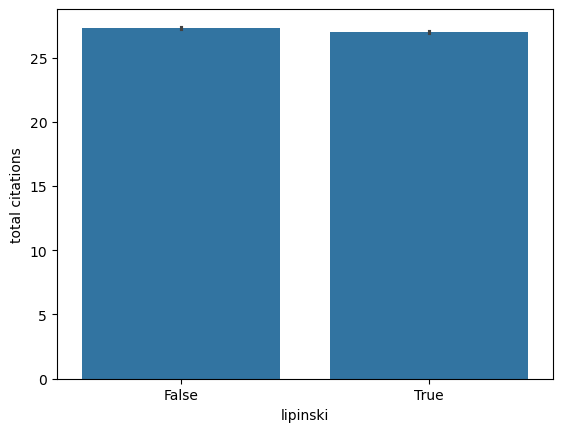

In [142]:
sns.barplot(lipinski_pat, x="lipinski", y="total citations")
lipinski_diff_in_mean = (
    lipinski_pat.query("lipinski==False")["total citations"].mean()
    - lipinski_pat.query("lipinski==True")["total citations"].mean()
)
t_test = ttest_ind(
    a=lipinski_pat.query("lipinski==True")["total citations"],
    b=lipinski_pat.query("lipinski==False")["total citations"],
    equal_var=False,
)
print(f"Difference in mean citations: {lipinski_diff_in_mean:.3f}")
print(
    f"T-test Results:\n\t- Statistic: t={t_test.statistic}\n\t- P-value: p={t_test.pvalue:.3e}"
)

final story for this part:

- classify by follows "normal" cp kinetics,
- we see there is way more in this, and that this class seems to have higher counts of following lipinski's rule,
- but does follow this rule lead to higher success metrics?
    - not really in publication citations
    - in patents?

------------

In [ ]:
# 70 mins to run
entire["lipinski"] = entire["Ligand SMILES"].apply(lipinski)

[16:09:52] non-ring atom 28 marked aromatic
[16:09:53] non-ring atom 28 marked aromatic


Invalid SMILES string.
Invalid SMILES string.


[16:09:54] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.


[16:10:16] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:10:16] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:10:47] Explicit valence for atom # 17 O, 3, is greater than permitted
[16:10:47] Explicit valence for atom # 16 O, 3, is greater than permitted
[16:10:47] Explicit valence for atom # 16 O, 3, is greater than permitted
[16:10:47] Explicit valence for atom # 17 O, 3, is greater than permitted
[16:10:47] Explicit valence for atom # 16 O, 3, is greater than permitted
[16:10:47] Explicit valence for atom # 16 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:12:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[16:12:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16
[16:12:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[16:12:49] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:12:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:12:55] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[16:12:55] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[16:12:55] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[16:12:55] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[16:12:55] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[16:12:55] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[16:12:55] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:12:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:12:56] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:13:06] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 17 18 19 30 31 32
[16:13:06] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 16 17 18 28 29 30
[16:13:06] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 16 17 18 29 30 31


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:13:18] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:18] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:13:40] Explicit valence for atom # 3 C, 5, is greater than permitted


Invalid SMILES string.


[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:13:58] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:59] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:59] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:13:59] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:59] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:59] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:59] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:13:59] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:14:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:14:02] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:14:32] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[16:14:33] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[16:14:35] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:14:35] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:14:35] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:14:35] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:14:35] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16


Invalid SMILES string.


[16:14:44] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.


[16:14:46] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.


[16:14:49] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:14:49] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:14:49] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:15:14] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.


[16:15:15] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.


[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 34 35 36
[16:15:18] Can't

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 33 34 35
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 34 35 36
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 28 29 30
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:15:

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:15:39] Explicit valence for atom # 66 N, 4, is greater than permitted
[16:15:39] Explicit valence for atom # 64 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:15:56] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:15:56] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:16:05] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 35 36 37 38 39
[16:16:05] Can't kekulize mol.  Unkekulized atoms: 29 30 31 33 34
[16:16:05] Can't kekulize mol.  Unkekulized atoms: 29 30 31 33 34


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:16:10] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[16:16:10] Can't kekulize mol.  Unkekulized atoms: 20 21 22


Invalid SMILES string.
Invalid SMILES string.


[16:16:24] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:16:24] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:16:24] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:16:36] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[16:16:36] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:16:36] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:16:37] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[16:16:39] Can't kekulize mol.  Unkekulized atoms: 3 18 19 20 21 22 23


Invalid SMILES string.


[16:16:43] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:16:43] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:16:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:16:43] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:16:50] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 10 12


Invalid SMILES string.


[16:16:52] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21


Invalid SMILES string.


[16:16:58] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[16:17:15] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[16:17:16] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:17:16] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:17:19] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 36
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 39
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 18 19 22 23 25
[16:17:19] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[16:17:19] Can

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:17:20] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 39
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 22 23 25
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:20] Can

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:17:22] Explicit valence for atom # 27 N, 4, is greater than permitted
[16:17:22] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:17:22] Explicit valence for atom # 27 N, 4, is greater than permitted
[16:17:22] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:17:22] Explicit valence for atom # 27 N, 4, is greater than permitted
[16:17:22] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:17:22] Explicit valence for atom # 27 N, 4, is greater than permitted
[16:17:22] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:17:23] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:17:23] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:17:23] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:17:23] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:17:23] Explicit valence for atom # 33 N, 4, is greater than permitted
[16:17:23] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:17:27] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14
[16:17:27] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14
[16:17:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 20 21 23 24
[16:17:27] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18 20 21


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:17:42] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[16:17:42] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.


[16:17:45] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:17:48] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19


Invalid SMILES string.


[16:17:52] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:17:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:17:54] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:17:57] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:57]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:17:57] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
[16:17:57] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:17:58] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[16:18:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 28


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:18:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:01] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[16:18:02] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[16:18:02] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 29
[16:18:02] Can't kekulize mol.  Unkekulized atoms: 2 3 28
[16:18:02] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:18:03] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:18:03] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:18:03] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:18:05] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:18:07] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[16:18:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 11 13 14 15 16
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 20
[16:18:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 21
[16:18:07] Can't kekulize mol. 

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:18:11] Can't kekulize mol.  Unkekulized atoms: 7 8 15 16 17


Invalid SMILES string.


[16:18:12] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25


Invalid SMILES string.


[16:18:12] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 18 20
[16:18:12] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 17 19
[16:18:12] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 8 9
[16:18:12] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 19 20 21
[16:18:12] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 17 18
[16:18:12] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:18:13] Can't kekulize mol.  Unkekulized atoms: 15 16 17 31 32 34 35 36 37


Invalid SMILES string.


[16:18:15] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:18:16] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:18:16] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[16:18:16] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:18:17] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:18:17] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:18:17] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:18:17] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:18:24] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.


[16:18:30] Explicit valence for atom # 32 N, 4, is greater than permitted


Invalid SMILES string.


[16:18:32] Can't kekulize mol.  Unkekulized atoms: 18 20 21 22 23
[16:18:32] Can't kekulize mol.  Unkekulized atoms: 13 15 16 17 18
[16:18:32] Can't kekulize mol.  Unkekulized atoms: 15 17 18 19 20
[16:18:32] Can't kekulize mol.  Unkekulized atoms: 22 24 25 26 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:18:52] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:18:52] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:18:55] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15


Invalid SMILES string.


[16:19:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21 22 23 24 25
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 18 19 20 21 22 23
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:19:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
[16:19:02] Can't kekulize mol.  Unk

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:19:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:19:04] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:19:04] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:19:04] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:19:04] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:19:07] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:19:07] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:19:07] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:19:07] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:19:07] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:19:14] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 33


Invalid SMILES string.


[16:19:18] Explicit valence for atom # 18 N, 4, is greater than permitted


Invalid SMILES string.


[16:19:29] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[16:19:45] Explicit valence for atom # 16 N, 5, is greater than permitted


Invalid SMILES string.


[16:19:50] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 14


Invalid SMILES string.


[16:19:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 23 24
[16:19:51] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20


Invalid SMILES string.
Invalid SMILES string.


[16:19:54] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:19:54] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:19:58] Explicit valence for atom # 49 N, 4, is greater than permitted
[16:19:58] Explicit valence for atom # 49 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:20:03] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21
[16:20:03] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21


Invalid SMILES string.
Invalid SMILES string.


[16:20:04] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 38 39 40
[16:20:04] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 38 39 40


Invalid SMILES string.
Invalid SMILES string.


[16:20:21] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:20:21] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:20:21] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:20:21] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:20:21] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:20:21] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:20:24] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[16:20:41] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31


Invalid SMILES string.


[16:20:54] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


Invalid SMILES string.


[16:20:56] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[16:21:14] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 19


Invalid SMILES string.


[16:21:29] Can't kekulize mol.  Unkekulized atoms: 23 24 25
[16:21:29] Can't kekulize mol.  Unkekulized atoms: 29 30 31


Invalid SMILES string.
Invalid SMILES string.


[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 8 9 10 19 20
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:21:31] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 9 10 11 20 21
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:21:31] Can't kekulize mol.  Unkekuliz

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:21:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:21:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:21:36] Can't kekulize mol.  Unk

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:21:40] Can't kekulize mol.  Unkekulized atoms: 14 15 16


Invalid SMILES string.


[16:21:42] Can't kekulize mol.  Unkekulized atoms: 23 25 26
[16:21:42] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:21:42] Can't kekulize mol.  Unkekulized atoms: 7 8 9


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 8 9 11 12 13
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 8 9 11 12 13
[16:21:44] Can't kekulize mol.  Unkekulized atoms: 8 9 11 12 13
[16:21:44] Can't

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:21:45] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


Invalid SMILES string.


[16:21:46] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 22
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 22
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:21:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:21:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:21:48] Can't kekulize mol.  Unkekulized atoms: 2 3 19 21 22


Invalid SMILES string.
Invalid SMILES string.


[16:21:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:21:48] Can't kekulize mol.  Unkekulized atoms: 2 3 19 21 22


Invalid SMILES string.
Invalid SMILES string.


[16:22:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Invalid SMILES string.


[16:22:02] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[16:22:13] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:22:13] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:22:14] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:22:14] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:22:26] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:22:26] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:22:26] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:22:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:22:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:22:27] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:22:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[16:22:29] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 11 12 14
[16:22:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:22:34] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:22:34] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:22:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 27


Invalid SMILES string.


[16:22:48] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14


Invalid SMILES string.


[16:22:48] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:22:48] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:22:50] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 24
[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 24
[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24
[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
[16:22:51] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:22:54] Explicit valence for atom # 41 N, 4, is greater than permitted


Invalid SMILES string.


[16:23:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:23:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:23:26] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:23:30] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:23:37] Explicit valence for atom # 41 N, 4, is greater than permitted
[16:23:37] Explicit valence for atom # 41 N, 4, is greater than permitted
[16:23:37] Explicit valence for atom # 41 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:23:43] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[16:23:59] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[16:24:01] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:24:11] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:24:22] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:24:22] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:24:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:24:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:24:22] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:24:22] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:24:22] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:24:34] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15


Invalid SMILES string.


[16:24:38] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[16:24:38] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33


Invalid SMILES string.
Invalid SMILES string.


[16:24:43] Can't kekulize mol.  Unkekulized atoms: 3 4 8
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 2 3 23
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 18 19 23
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 18 19 23
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 13 14 18
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 13 14 18
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 13 14 18
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 3 20 24
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 1 2 24
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 1 2 23
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 1 2 23
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 17 18 22
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 17 18 22
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 15 16 20
[16:24:43] Can't kekulize mol.  Unkekulized atoms: 1 2 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:24:55] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:24:55] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:24:55] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:25:03] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:25:04] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:25:07] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18 19 20 21 22
[16:25:07] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22 23 24 25 26
[16:25:07] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22 23 24 25 26
[16:25:07] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18 20 21 22 23
[16:25:07] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18 20 21 22 23


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:25:25] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:25:25] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 18 19 23
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 23 24 28
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 20 21 25
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 20 21 25
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't ke

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:25:30] Can't kekulize mol.  Unkekulized atoms: 36 37 39
[16:25:30] Can't kekulize mo

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 4 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 23 24 27
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 23 24 27
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:25:31] Can't kekulize

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:25:47] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26


Invalid SMILES string.


[16:26:03] Explicit valence for atom # 35 N, 4, is greater than permitted
[16:26:03] Explicit valence for atom # 35 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:26:06] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:26:06] Explicit valence for atom # 13 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:26:13] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[16:26:14] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[16:26:23] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[16:26:24] Explicit valence for atom # 33 N, 4, is greater than permitted
[16:26:24] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:26:24] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:26:24] Explicit valence for atom # 34 N, 4, is greater than permitted
[16:26:24] Explicit valence for atom # 36 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:26:37] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.


[16:26:39] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:26:43] non-ring atom 14 marked aromatic
[16:26:43] non-ring atom 14 marked aromatic


Invalid SMILES string.
Invalid SMILES string.


[16:26:49] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:26:49] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 36
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 39
[16:26:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 39
[16:26:49] Can't k

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:26:49] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:26:49] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:26:50] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:26:50] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:26:50] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:26:50] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:26:50] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:26:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:26:51] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:26:52] Explicit valence for atom # 11 N, 4, is greater than permitted


Invalid SMILES string.


[16:26:52] Explicit valence for atom # 11 N, 4, is greater than permitted


Invalid SMILES string.


[16:27:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:27:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:27:40] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:27:45] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[16:27:48] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:27:48] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:27:48] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:27:48] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:27:54] Can't kekulize mol.  Unkekulized atoms: 34 35 38
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 34 35 38
[16:27:54] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:27:54] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[16:27:54

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:27:59] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:28:02] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:28:02] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:28:02] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:28:02] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:28:08] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:28:08] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:28:08] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:28:18] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.


[16:28:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:28:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:28:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:28:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:28:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:28:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:28:26] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:28:29] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[16:28:29] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[16:28:29] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[16:28:29] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[16:28:29] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[16:28:29] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 21
[16:28:30]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:28:30] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[16:28:30] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23


Invalid SMILES string.
Invalid SMILES string.


[16:28:38] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:28:38] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:28:38] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:28:52] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 30 31 33
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 30 31 33
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:28:52] Can't kekulize mol.  Unkekulized atoms: 1 2 6


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:29:02] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:29:16] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.


[16:29:17] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:29:17] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:29:17] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:29:17] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:29:17] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:29:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:29:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:29:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:29:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:29:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:29:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:29:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:29:17] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:29:20] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[16:29:20] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[16:29:24] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[16:29:26] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:29:26] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:29:26] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:29:32] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28


Invalid SMILES string.


[16:29:36] Explicit valence for atom # 24 N, 4, is greater than permitted
[16:29:36] Explicit valence for atom # 24 N, 4, is greater than permitted
[16:29:36] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:29:41] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
[16:29:41] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
[16:29:41] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
[16:29:41] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
[16:29:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[16:29:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[16:29:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[16:29:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:29:44] Explicit valence for atom # 24 N, 4, is greater than permitted
[16:29:44] Explicit valence for atom # 24 N, 4, is greater than permitted
[16:29:44] Explicit valence for atom # 24 N, 4, is greater than permitted
[16:29:44] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:02] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:30:02] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:30:05] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:30:05] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:30:05] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:30:05] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:30:05] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:05] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:30:05] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:30:05] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:06] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:30:06] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[16:30:06] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:30:06] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:30:06] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:30:06] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:30:06] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:30:06] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 23 24


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:08] Can't kekulize mol.  Unkekulized atoms: 2 3 4 30 32


Invalid SMILES string.


[16:30:11] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:30:11] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:30:11] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:30:11] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:30:11] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:30:11] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:30:11] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:30:11] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:30:11] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:13] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 21


Invalid SMILES string.


[16:30:17] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[16:30:21] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 34 35 36 37 38 44 45


Invalid SMILES string.


[16:30:22] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 10 11 24 25


Invalid SMILES string.


[16:30:23] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 28 29
[16:30:23] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20


Invalid SMILES string.
Invalid SMILES string.


[16:30:29] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:29] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:29] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:37] Explicit valence for atom # 41 N, 4, is greater than permitted


Invalid SMILES string.


[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:30:42] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:49] Explicit valence for atom # 41 N, 4, is greater than permitted


Invalid SMILES string.


[16:30:50] Can't kekulize mol.  Unkekulized atoms: 24 25 26 28 29


Invalid SMILES string.


[16:30:55] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[16:30:56] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 28


Invalid SMILES string.


[16:30:58] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:30:58] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:30:58] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:30:58] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:30:59] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:30:59] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:30:59] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:59] Explicit valence for atom # 27 N, 4, is greater than permitted
[16:30:59] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:30:59] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:30:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:30:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:31:00] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:31:00] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:31:00] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:31:00] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:31:00] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.


[16:31:02] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:31:02] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:31:05] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:31:10] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:31:10] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:31:11] Explicit valence for atom # 36 N, 4, is greater than permitted


Invalid SMILES string.


[16:31:15] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 26 27
[16:31:15] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:31:15] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:31:15] Explicit valence for atom # 7 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:31:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 34
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 33 34
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 34
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:31:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 34
[16:31:16] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[16:31:16] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[16:31:16] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:31:16] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:31:25] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[16:31:25] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29


Invalid SMILES string.
Invalid SMILES string.


[16:31:27] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.


[16:31:43] Can't kekulize mol.  Unkekulized atoms: 8 10 12
[16:31:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 14 15 16 17 18 19
[16:31:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 24 25
[16:31:43] Explicit valence for atom # 1 Cl, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:31:43] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[16:31:43] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9


Invalid SMILES string.
Invalid SMILES string.


[16:31:44] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:31:44] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:31:47] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:31:47] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:32:03] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 29
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 21
[16:32:03]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:32:03] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
[16:32:03] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23


Invalid SMILES string.


[16:32:04] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.


[16:32:15] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[16:32:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
[16:32:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
[16:32:17] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 34
[16:32:17] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 34


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:32:18] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 11 12 13
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 11 12 13
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11 12 13
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 19 20
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 29 30
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 22 23
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:32:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 11 12 13
[16:32:18] Can't kekulize mol.  U

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:32:24] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:32:26] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:32:37] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:32:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27


Invalid SMILES string.


[16:32:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 14
[16:32:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 14


Invalid SMILES string.
Invalid SMILES string.


[16:33:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:33:04] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:33:05] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:33:05] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:33:13] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:33:24] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[16:33:25] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:33:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:33:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:33:26] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:33:26] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:33:26] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:33:28] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34


Invalid SMILES string.


[16:33:31] Explicit valence for atom # 20 H, 2, is greater than permitted


Invalid SMILES string.


[16:33:31] non-ring atom 1 marked aromatic


Invalid SMILES string.


[16:33:31] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:33:31] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9


Invalid SMILES string.
Invalid SMILES string.


[16:33:36] Explicit valence for atom # 6 O, 3, is greater than permitted


Invalid SMILES string.


[16:33:40] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:33:40] Explicit valence for atom # 7 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:33:43] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[16:34:00] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.


[16:34:04] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 31
[16:34:04] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 31


Invalid SMILES string.
Invalid SMILES string.


[16:34:06] Explicit valence for atom # 2 O, 3, is greater than permitted


Invalid SMILES string.


[16:34:13] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:34:13] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:34:13] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:34:13] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:34:13] Explicit valence for atom # 20 O, 3, is greater than permitted
[16:34:13] Explicit valence for atom # 14 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:34:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:34:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:34:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:34:20] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.


[16:34:23] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[16:34:23] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14
[16:34:23] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14
[16:34:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 14 15 16
[16:34:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 14 15 16


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:34:32] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[16:34:34] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:34:34] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:34:35] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:34:41] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:34:41] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:34:41] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:34:41] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:34:41] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:34:41] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:34:48] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:34:48] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:35:01] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 29
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[16:35:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 31
[16:35:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[16:35:02] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:35:02] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 29
[16:35:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[16:35:02] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 30
[16:35:02] Can't kekulize mol.  Unkekulized atoms: 4 

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:35:02] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.


[16:35:08] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:35:08] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 1

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:35:08] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23
[16:35:10] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[16:35:15] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[16:35:15] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34


Invalid SMILES string.
Invalid SMILES string.


[16:35:18] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 28 29 30


Invalid SMILES string.


[16:35:20] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:35:20] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:35:20] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:35:20] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:35:21] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:35:21] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:35:21] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:35:21] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:35:27] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.


[16:35:28] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:35:28] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:35:30] Explicit valence for atom # 12 H, 2, is greater than permitted


Invalid SMILES string.


[16:35:33] Explicit valence for atom # 1 Cl, 4, is greater than permitted
[16:35:33] Explicit valence for atom # 1 Cl, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 23 24 25
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 24 25
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 30 31
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 31 32
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 24 25
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 30 31
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
[16:35:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:35:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:35:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:35:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:35:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:35:40] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:35:40] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:35:45] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[16:35:46] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:35:46] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:35:49] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:35:49] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:35:49] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:35:49] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:35:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 18 19 20 21
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 19 20 21 22
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 29 30 31
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 28 29 30 31
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 30 31
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 18 19 20 21
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 19 20 21 22
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 29 30 31
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 28 29 30 31
[16:35:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 30 31


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:35:56] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.


[16:36:00] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[16:36:00] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[16:36:00] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[16:36:00] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
[16:36:00] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:36:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:36:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:36:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:36:09] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:36:16] Explicit valence for atom # 66 N, 4, is greater than permitted
[16:36:16] Explicit valence for atom # 66 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:36:21] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25


Invalid SMILES string.


[16:36:22] Can't kekulize mol.  Unkekulized atoms: 4 5 27 28 29 30 31 32 33
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 23 25 26
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:36:28] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:36:28] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:36:28] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:36:28] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:36:28] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[16:36:28] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[16:36:28] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[16:36:28] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[16:36:29] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.


[16:36:29] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[16:36:35] Can't kekulize mol.  Unkekulized atoms: 18 19 21
[16:36:35] Can't kekulize mol.  Unkekulized atoms: 18 20 22


Invalid SMILES string.
Invalid SMILES string.


[16:36:46] Explicit valence for atom # 34 N, 4, is greater than permitted
[16:36:46] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:36:50] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
[16:36:50] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
[16:36:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:36:50] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:36:59] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
[16:36:59] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34


Invalid SMILES string.
Invalid SMILES string.


[16:37:06] Explicit valence for atom # 20 H, 2, is greater than permitted
[16:37:06] Explicit valence for atom # 20 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:37:09] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.


[16:37:14] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:37:14] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:37:14] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:37:16] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:37:16] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:37:18] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 30
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 34
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 35
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 40
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 33
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 30
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 37
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 36
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 38
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 40
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 34
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 33
[16:37:18] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 3

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:37:25] Explicit valence for atom # 37 N, 4, is greater than permitted


Invalid SMILES string.


[16:37:26] Explicit valence for atom # 36 N, 4, is greater than permitted


Invalid SMILES string.


[16:37:34] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:37:34] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 25


Invalid SMILES string.
Invalid SMILES string.


[16:37:40] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:37:40] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:37:47] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:37:47] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:37:47] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:37:51] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:37:52] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:37:59] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:37:59] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:37:59] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:38:00] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:38:00] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.


[16:38:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:38:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:38:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:38:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:38:09] Explicit valence for atom # 33 H, 2, is greater than permitted
[16:38:09] Explicit valence for atom # 31 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:38:13] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:38:13] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:38:13] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:38:27] Explicit valence for atom # 23 N, 4, is greater than permitted


Invalid SMILES string.


[16:38:28] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:38:28] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[16:38:34] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 10
[16:38:34] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 39
[16:38:34] Can't kekulize mol.  Unkekulized atoms: 7 8 10 12 15
[16:38:34] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44 45 46 47 49


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:38:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 22 23


Invalid SMILES string.


[16:38:50] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:38:50] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:38:50] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:38:50] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
[16:38:50] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
[16:38:50] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
[16:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:38:51] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
[16:38:51] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:38:55] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:38:55] Can't kekulize mol.  Unkekulized atoms: 1 3 5


Invalid SMILES string.
Invalid SMILES string.


[16:39:01] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:39:01] Explicit valence for atom # 32 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:39:04] Explicit valence for atom # 18 C, 5, is greater than permitted


Invalid SMILES string.


[16:39:09] Explicit valence for atom # 33 N, 4, is greater than permitted
[16:39:09] Explicit valence for atom # 33 N, 4, is greater than permitted
[16:39:09] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:39:09] Explicit valence for atom # 33 N, 4, is greater than permitted
[16:39:09] Explicit valence for atom # 33 N, 4, is greater than permitted
[16:39:09] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:39:09] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:39:13] Explicit valence for atom # 19 C, 5, is greater than permitted


Invalid SMILES string.


[16:39:14] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:39:14] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:39:16] Explicit valence for atom # 21 O, 3, is greater than permitted


Invalid SMILES string.


[16:39:17] Explicit valence for atom # 33 H, 2, is greater than permitted
[16:39:17] Explicit valence for atom # 31 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:39:25] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:39:25] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:39:25] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:39:29] Explicit valence for atom # 10 C, 5, is greater than permitted
[16:39:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 9 10 23 24


Invalid SMILES string.
Invalid SMILES string.


[16:39:30] Explicit valence for atom # 20 N, 4, is greater than permitted


Invalid SMILES string.


[16:39:30] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[16:39:30] Explicit valence for atom # 31 C, 5, is greater than permitted
[16:39:31] Explicit valence for atom # 9 C, 5, is greater than permitted
[16:39:31] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:39:31] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:39:31] Explicit valence for atom # 19 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:39:32] Explicit valence for atom # 27 H, 2, is greater than permitted
[16:39:32] Explicit valence for atom # 28 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:39:35] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[16:39:38] Explicit valence for atom # 17 O, 3, is greater than permitted


Invalid SMILES string.


[16:39:41] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[16:39:43] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:39:43] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:39:44] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[16:39:45] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.


[16:39:46] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:39:50] Explicit valence for atom # 16 C, 5, is greater than permitted


Invalid SMILES string.


[16:39:59] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 31 32 34 35 37
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
[16:39:59]

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:40:00] Explicit valence for atom # 0 C, 5, is greater than permitted


Invalid SMILES string.


[16:40:01] Explicit valence for atom # 28 N, 4, is greater than permitted
[16:40:01] Explicit valence for atom # 28 N, 4, is greater than permitted
[16:40:01] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:03] Explicit valence for atom # 13 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 12 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 12 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 26 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 25 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 11 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 11 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 26 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 10 C, 6, is greater than permitted
[16:40:03] Explicit valence for atom # 6 C, 6, is greater than permitted
[16:40:03] Explicit valence for atom # 10 C, 6, is greater than permitted
[16:40:03] Explicit valence for atom # 10

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:06] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[16:40:11] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:40:11] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:40:11] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:12] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:40:12] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:40:12] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:13] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:40:13] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:40:13] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 20 22


Invalid SMILES string.


[16:40:24] Explicit valence for atom # 10 N, 4, is greater than permitted


Invalid SMILES string.


[16:40:29] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9


Invalid SMILES string.


[16:40:31] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[16:40:40] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:40:40] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:40:40] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:40:40] Explicit valence for atom # 29 N, 4, is greater than permitted
[16:40:40] Explicit valence for atom # 28 N, 4, is greater than permitted
[16:40:40] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:41] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:40:41] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:40:41] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:41] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[16:40:45] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:40:45] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:40:45] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:40:45] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:40:45] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:40:45] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:40:45] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:40:45] Can't kekulize mol.  Unkekulized atoms: 14 15 17


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 22 23 24
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 4 7 8 11 12 13 14 28 29
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 24 25 26
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 22 23 24
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 4 7 8 11 12 13 14 28 29
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 24 25 26
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:46] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 24 25 26
[16:40:46] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 24 25 26


Invalid SMILES string.
Invalid SMILES string.


[16:40:47] Explicit valence for atom # 28 H, 2, is greater than permitted
[16:40:47] Explicit valence for atom # 27 H, 2, is greater than permitted
[16:40:47] Explicit valence for atom # 28 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:54] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:40:54] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:40:54] Explicit valence for atom # 5 O, 5, is greater than permitted
[16:40:54] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28
[16:40:54] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24
[16:40:54] Can't kekulize mol.  Unkekulized atoms: 19 20 23
[16:40:54] Can't kekulize mol.  Unkekulized atoms: 13 14 17


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 18 20
[16:40:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21
[16:40:56] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15 16 17 18 19


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21
[16:40:56] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
[16:40:56] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
[16:40:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17
[16:40:57] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:40:58] Explicit valence for atom # 4 H, 2, is greater than permitted


Invalid SMILES string.


[16:41:00] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[16:41:00] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34


Invalid SMILES string.
Invalid SMILES string.


[16:41:05] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 12 14 15 16


Invalid SMILES string.


[16:41:10] Explicit valence for atom # 18 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 18 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 18 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 18 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:41:10] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:41:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:41:11] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:11] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:41:11] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:41:12] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:41:12] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:41:12] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:13] Explicit valence for atom # 11 H, 3, is greater than permitted
[16:41:13] Explicit valence for atom # 11 H, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:41:13] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:41:13] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:41:13] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:41:13] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:17] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27


Invalid SMILES string.


[16:41:18] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
[16:41:18] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24


Invalid SMILES string.
Invalid SMILES string.


[16:41:19] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.


[16:41:28] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:41:32] Explicit valence for atom # 30 O, 3, is greater than permitted
[16:41:32] Explicit valence for atom # 30 O, 3, is greater than permitted
[16:41:32] Explicit valence for atom # 30 O, 3, is greater than permitted
[16:41:32] Explicit valence for atom # 30 O, 3, is greater than permitted
[16:41:32] Explicit valence for atom # 30 O, 3, is greater than permitted
[16:41:32] Explicit valence for atom # 30 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:32] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 20 21
[16:41:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23
[16:41:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23
[16:41:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23
[16:41:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23
[16:41:32] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 20 21
[16:41:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 22 23


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:35] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:35] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:35] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:36] Explicit valence for atom # 28 N, 4, is greater than permitted
[16:41:36] Explicit valence for atom # 28 N, 4, is greater than permitted
[16:41:36] Explicit valence for atom # 28 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:41:37] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:39] Explicit valence for atom # 27 O, 3, is greater than permitted


Invalid SMILES string.


[16:41:45] Explicit valence for atom # 27 H, 2, is greater than permitted
[16:41:45] Explicit valence for atom # 30 H, 2, is greater than permitted
[16:41:45] Explicit valence for atom # 31 H, 2, is greater than permitted
[16:41:45] Explicit valence for atom # 28 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:46] Can't kekulize mol.  Unkekulized atoms: 1 2 5


Invalid SMILES string.


[16:41:47] Explicit valence for atom # 29 C, 5, is greater than permitted


Invalid SMILES string.


[16:41:52] Explicit valence for atom # 17 C, 6, is greater than permitted
[16:41:52] Explicit valence for atom # 17 S, 8, is greater than permitted
[16:41:52] Explicit valence for atom # 12 C, 6, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:52] Explicit valence for atom # 6 C, 6, is greater than permitted


Invalid SMILES string.


[16:41:53] Explicit valence for atom # 16 C, 6, is greater than permitted
[16:41:53] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18
[16:41:53] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:41:56] Explicit valence for atom # 22 H, 3, is greater than permitted


Invalid SMILES string.


[16:41:59] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.


[16:42:00] Explicit valence for atom # 5 O, 3, is greater than permitted
[16:42:00] Explicit valence for atom # 34 N, 4, is greater than permitted
[16:42:00] Explicit valence for atom # 36 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:42:00] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[16:42:01] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:42:01] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:42:01] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:42:02] Explicit valence for atom # 20 N, 4, is greater than permitted


Invalid SMILES string.


[16:42:06] Explicit valence for atom # 27 N, 4, is greater than permitted
[16:42:06] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:42:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[16:42:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


Invalid SMILES string.
Invalid SMILES string.


[16:42:10] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38 39 40 41 42


Invalid SMILES string.


[16:42:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Invalid SMILES string.


[16:42:13] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[16:42:15] Explicit valence for atom # 9 H, 2, is greater than permitted


Invalid SMILES string.


[16:42:15] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:42:15] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18 21 22 23 24


Invalid SMILES string.
Invalid SMILES string.


[16:42:16] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 15
[16:42:16] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 15


Invalid SMILES string.
Invalid SMILES string.


[16:42:21] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[16:42:23] Explicit valence for atom # 66 N, 4, is greater than permitted
[16:42:23] Explicit valence for atom # 66 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:42:23] Explicit valence for atom # 8 N, 4, is greater than permitted


Invalid SMILES string.


[16:42:24] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[16:42:24] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:42:27] Explicit valence for atom # 61 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 61 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 57 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 57 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 58 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 58 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 62 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 62 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 60 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 60 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 56 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 56 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom # 61 H, 2, is greater than permitted
[16:42:27] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:42:29] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[16:42:29] Explicit valence for atom # 23 Cl, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:42:29] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.


[16:42:31] Explicit valence for atom # 5 O, 3, is greater than permitted
[16:42:31] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:42:32] Explicit valence for atom # 43 N, 4, is greater than permitted


Invalid SMILES string.


[16:42:34] Explicit valence for atom # 27 N, 4, is greater than permitted
[16:42:34] Explicit valence for atom # 27 N, 4, is greater than permitted
[16:42:34] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:42:34] Explicit valence for atom # 28 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:42:34] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26


Invalid SMILES string.


[16:42:38] Explicit valence for atom # 22 O, 3, is greater than permitted
[16:42:38] Explicit valence for atom # 22 O, 3, is greater than permitted
[16:42:38] Explicit valence for atom # 25 C, 5, is greater than permitted
[16:42:38] Explicit valence for atom # 25 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:42:41] Can't kekulize mol.  Unkekulized atoms: 8 9 10 23 24 25 26 27 28
[16:42:41] Can't kekulize mol.  Unkekulized atoms: 9 10 11 24 25 26 27 28 29
[16:42:41] Can't kekulize mol.  Unkekulized atoms: 8 9 10 23 24 25 26 27 28


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:42:43] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27
[16:42:43] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27
[16:42:43] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28
[16:42:43] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28
[16:42:43] Can't kekulize mol.  Unkekulized atoms: 21 22 23 25 26
[16:42:43] Can't kekulize mol.  Unkekulized atoms: 21 22 23 25 26


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:42:45] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 39


Invalid SMILES string.


[16:42:49] Explicit valence for atom # 8 O, 3, is greater than permitted


Invalid SMILES string.


[16:42:57] Explicit valence for atom # 35 N, 4, is greater than permitted


Invalid SMILES string.


[16:42:57] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[16:43:02] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[16:43:02] Explicit valence for atom # 48 N, 4, is greater than permitted


Invalid SMILES string.


[16:43:03] Explicit valence for atom # 28 H, 3, is greater than permitted


Invalid SMILES string.


[16:43:03] Explicit valence for atom # 28 H, 3, is greater than permitted


Invalid SMILES string.


[16:43:19] Explicit valence for atom # 20 H, 2, is greater than permitted
[16:43:19] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:43:19] Explicit valence for atom # 11 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:43:20] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:43:20] Explicit valence for atom # 6 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:43:22] Explicit valence for atom # 18 O, 5, is greater than permitted
[16:43:22] Explicit valence for atom # 19 O, 5, is greater than permitted
[16:43:22] Explicit valence for atom # 19 O, 5, is greater than permitted
[16:43:22] Explicit valence for atom # 13 H, 2, is greater than permitted
[16:43:22] Explicit valence for atom # 13 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:43:22] Explicit valence for atom # 13 H, 2, is greater than permitted
[16:43:22] Explicit valence for atom # 13 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:43:22] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:43:22] Explicit valence for atom # 2 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:43:25] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:43:25] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:43:26] Explicit valence for atom # 22 H, 3, is greater than permitted
[16:43:26] Explicit valence for atom # 22 H, 3, is greater than permitted
[16:43:26] Explicit valence for atom # 22 H, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:43:29] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 41 42 43
[16:43:29] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 41 42 43
[16:43:29] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 41 42 43
[16:43:29] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45
[16:43:29] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45
[16:43:29] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
[16:43:29] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
[16:43:29] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:43:29] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 40 41 42
[16:43:29] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45


Invalid SMILES string.
Invalid SMILES string.


[16:43:30] Can't kekulize mol.  Unkekulized atoms: 37 38 40 41 44 45 46
[16:43:30] Can't kekulize mol.  Unkekulized atoms: 37 38 40 41 44 45 46


Invalid SMILES string.
Invalid SMILES string.


[16:43:30] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.


[16:43:34] Can't kekulize mol.  Unkekulized atoms: 15 16 24 25 26 31 32
[16:43:34] Can't kekulize mol.  Unkekulized atoms: 15 16 24 25 26 31 32
[16:43:34] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:43:36] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 25


Invalid SMILES string.


[16:43:38] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:43:38] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:43:38] Explicit valence for atom # 21 N, 4, is greater than permitted
[16:43:38] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:43:39] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[16:43:42] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31
[16:43:42] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31


Invalid SMILES string.
Invalid SMILES string.


[16:43:44] Explicit valence for atom # 21 H, 2, is greater than permitted
[16:43:44] Explicit valence for atom # 15 C, 5, is greater than permitted
[16:43:44] Explicit valence for atom # 15 C, 5, is greater than permitted
[16:43:44] Explicit valence for atom # 15 C, 5, is greater than permitted
[16:43:44] Explicit valence for atom # 15 C, 5, is greater than permitted
[16:43:44] Explicit valence for atom # 11 C, 5, is greater than permitted
[16:43:44] Explicit valence for atom # 11 C, 5, is greater than permitted
[16:43:44] Explicit valence for atom # 11 C, 5, is greater than permitted
[16:43:44] Explicit valence for atom # 11 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:43:45] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[16:43:48] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:43:48] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:43:48] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:43:48] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:43:48] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:43:48] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:43:49] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


[16:43:54] Explicit valence for atom # 117 N, 4, is greater than permitted


Invalid SMILES string.


[16:43:56] Explicit valence for atom # 30 C, 5, is greater than permitted


Invalid SMILES string.


[16:44:00] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:44:00] Can't kekulize mol.  Unkekulized atoms: 16 17 18 25 26 27 28 29 30


Invalid SMILES string.
Invalid SMILES string.


[16:44:01] Explicit valence for atom # 6 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:02] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 21 22
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 23 24
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37 38 39 41 42


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:44:02] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 26 27
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 71 72 73 74 75
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 44 45 46 47 48
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 72 73
[16:44:02] Can't kekulize mol.  Unkekulized atoms: 4

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:44:03] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 26 27


Invalid SMILES string.


[16:44:03] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 87 88 89 90 91
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 71 72 73 74 75 76 77 79 80
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 44 45 46 47 48
[16:44:03] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:44:05] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:05] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47
[16:44:05] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:44:05] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:05] Can't kekulize mol.  Unkekulized atoms: 46 47 48 49 50
[16:44:05] non-ring atom 13 marked aromatic


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:44:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 30
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 30 33
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 30 33
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 30 33
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 30 33
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29
[16:44:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:44:11] Explicit valence for atom # 18 C, 5, is greater than permitted


Invalid SMILES string.


[16:44:13] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:44:13] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:44:13] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:44:13] Explicit valence for atom # 16 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:44:16] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:17] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:17] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:18] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 30 31 32 33


Invalid SMILES string.


[16:44:19] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 38 39
[16:44:19] Explicit valence for atom # 13 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:44:19] Explicit valence for atom # 13 O, 3, is greater than permitted


Invalid SMILES string.


[16:44:21] Can't kekulize mol.  Unkekulized atoms: 20 21 22
[16:44:21] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[16:44:21] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 31
[16:44:21] Can't kekulize mol.  Unkekulized atoms: 21 23 24


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:44:21] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24
[16:44:21] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8


Invalid SMILES string.
Invalid SMILES string.


[16:44:21] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 29
[16:44:26] Explicit valence for atom # 48 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:26] Explicit valence for atom # 48 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not removing hydrogen atom without neighbors
[16:44:27] WARNING: not r

Invalid SMILES string.


[16:44:33] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:35] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:37] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:39] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:41] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:43] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:44] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:47] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:47] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:49] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:50] Explicit valence for atom # 27 N, 4, is greater than permitted


Invalid SMILES string.


[16:44:54] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.


[16:44:55] Explicit valence for atom # 32 O, 3, is greater than permitted


Invalid SMILES string.


[16:44:55] Explicit valence for atom # 32 O, 3, is greater than permitted


Invalid SMILES string.


[16:45:00] Explicit valence for atom # 59 H, 2, is greater than permitted
[16:45:00] Explicit valence for atom # 59 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:45:02] Explicit valence for atom # 31 O, 3, is greater than permitted
[16:45:02] Explicit valence for atom # 4 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:45:05] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:45:05] Explicit valence for atom # 47 N, 4, is greater than permitted
[16:45:05] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:45:06] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[16:45:08] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24


Invalid SMILES string.


[16:45:15] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:45:15] Explicit valence for atom # 4 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:45:16] Can't kekulize mol.  Unkekulized atoms: 7 8 9 13 14


Invalid SMILES string.


[16:45:17] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:45:17] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25


Invalid SMILES string.
Invalid SMILES string.


[16:45:20] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:45:20] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:45:21] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.


[16:45:33] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[16:45:35] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[16:45:40] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:45:40] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:45:40] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:45:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 1 4 5
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 1 4 5
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 1 4 5
[16:45:41] Can't kekulize mol.  Unkek

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:45:41] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:45:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:42] Can't kekulize

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:45:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:45:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:45:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 8 9 11 13
[16:45:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 8 9 11 13


Invalid SMILES string.
Invalid SMILES string.


[16:45:46] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:45:46] Explicit valence for atom # 3 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:45:48] Explicit valence for atom # 13 H, 2, is greater than permitted
[16:45:48] Explicit valence for atom # 32 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:45:50] Explicit valence for atom # 18 N, 4, is greater than permitted


Invalid SMILES string.


[16:45:51] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:45:51] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:45:51] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:45:51] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:45:54] Explicit valence for atom # 30 Ga, 4, is greater than permitted
[16:45:54] Explicit valence for atom # 30 Ga, 4, is greater than permitted
[16:45:54] Explicit valence for atom # 30 Ga, 4, is greater than permitted
[16:45:54] Explicit valence for atom # 38 Ga, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:45:56] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[16:45:57] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.


[16:46:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:46:02] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:46:02] Explicit valence for atom # 10 C, 5, is greater than permitted


Invalid SMILES string.


[16:46:03] Explicit valence for atom # 5 C, 5, is greater than permitted
[16:46:03] Explicit valence for atom # 25 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:46:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:46:08] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:46:09] Explicit valence for atom # 16 C, 5, is greater than permitted


Invalid SMILES string.


[16:46:10] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:46:12] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:46:12] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:46:12] Explicit valence for atom # 32 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:46:13] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:46:13] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:46:13] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:46:13] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:46:13] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:46:13] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:46:14] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:46:14] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:46:14] Explicit valence for atom # 7 C, 5, is greater than permitted
[16:46:14] Explicit valence for atom # 14 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:46:15] Explicit valence for atom # 24 H, 3, is greater than permitted


Invalid SMILES string.


[16:46:19] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:46:24] Explicit valence for atom # 3 H, 2, is greater than permitted
[16:46:24] Explicit valence for atom # 3 H, 2, is greater than permitted
[16:46:25] Explicit valence for atom # 3 H, 2, is greater than permitted
[16:46:25] Explicit valence for atom # 3 H, 2, is greater than permitted
[16:46:25] Explicit valence for atom # 3 H, 2, is greater than permitted
[16:46:25] Explicit valence for atom # 3 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:46:25] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:46:25] Explicit valence for atom # 4 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:46:26] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:46:26] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:46:32] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:46:32] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:46:32] Explicit valence for atom # 7 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:46:35] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[16:46:36] Explicit valence for atom # 34 N, 4, is greater than permitted
[16:46:36] Explicit valence for atom # 34 N, 4, is greater than permitted
[16:46:36] Explicit valence for atom # 34 N, 4, is greater than permitted
[16:46:36] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:46:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:46:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:46:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:46:37] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:46:37] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:46:37] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:46:37] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:46:38] Explicit valence for atom # 1 O, 3, is greater than permitted


Invalid SMILES string.


[16:46:39] Explicit valence for atom # 22 H, 2, is greater than permitted


Invalid SMILES string.


[16:46:40] Explicit valence for atom # 26 N, 4, is greater than permitted


Invalid SMILES string.


[16:46:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:46:40] Explicit valence for atom # 18 O, 3, is greater than permitted
[16:46:40] Explicit valence for atom # 7 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:46:41] Explicit valence for atom # 12 C, 5, is greater than permitted


Invalid SMILES string.


[16:46:46] Explicit valence for atom # 19 O, 3, is greater than permitted
[16:46:46] non-ring atom 25 marked aromatic


Invalid SMILES string.
Invalid SMILES string.


[16:46:50] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:46:50] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:46:59] Explicit valence for atom # 5 O, 3, is greater than permitted
[16:46:59] Explicit valence for atom # 5 O, 3, is greater than permitted
[16:46:59] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:47:01] Explicit valence for atom # 2 N, 4, is 

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:47:02] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:47:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[16:47:02] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:47:02] Can't kekulize mol.  Unkekulized atoms: 4 5 38


Invalid SMILES string.


[16:47:03] Explicit valence for atom # 12 N, 4, is greater than permitted


Invalid SMILES string.


[16:47:04] Explicit valence for atom # 4 O, 3, is greater than permitted


Invalid SMILES string.


[16:47:07] Explicit valence for atom # 7 C, 5, is greater than permitted
[16:47:07] Explicit valence for atom # 7 C, 5, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:47:13] Explicit valence for atom # 13 N, 4, is greater than permitted


Invalid SMILES string.


[16:47:13] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.


[16:47:15] Explicit valence for atom # 34 N, 4, is greater than permitted
[16:47:15] Explicit valence for atom # 34 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:47:23] Explicit valence for atom # 5 O, 3, is greater than permitted


Invalid SMILES string.


[16:47:24] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:47:26] Explicit valence for atom # 27 H, 2, is greater than permitted
[16:47:26] Explicit valence for atom # 27 H, 2, is greater than permitted
[16:47:26] Explicit valence for atom # 27 H, 2, is greater than permitted
[16:47:26] Explicit valence for atom # 27 H, 2, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:47:26] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:47:26] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:47:28] non-ring atom 1 marked aromatic


Invalid SMILES string.


[16:47:33] Can't kekulize mol.  Unkekulized atoms: 3 4 5 16 17 18 19 20 21
[16:47:33] Can't kekulize mol.  Unkekulized atoms: 3 4 5 16 17 18 19 20 21


Invalid SMILES string.
Invalid SMILES string.


[16:47:34] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:47:34] Explicit valence for atom # 9 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:47:35] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[16:47:38] Explicit valence for atom # 25 N, 4, is greater than permitted


Invalid SMILES string.


[16:47:43] Explicit valence for atom # 19 N, 4, is greater than permitted
[16:47:43] Explicit valence for atom # 19 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


[16:47:47] Explicit valence for atom # 20 N, 4, is greater than permitted


Invalid SMILES string.


[16:47:52] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 40 43 44
[16:47:52] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 40 43 44


Invalid SMILES string.
Invalid SMILES string.


[16:47:55] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:47:55] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:47:55] Explicit valence for atom # 21 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:47:55] Explicit valence for atom # 7 N, 4, is greater than permitted


Invalid SMILES string.


[16:47:57] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[16:47:57] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 43 44


Invalid SMILES string.
Invalid SMILES string.


[16:48:00] Explicit valence for atom # 15 C, 6, is greater than permitted
[16:48:00] Explicit valence for atom # 15 C, 6, is greater than permitted
[16:48:00] Explicit valence for atom # 15 C, 6, is greater than permitted
[16:48:00] Explicit valence for atom # 17 C, 6, is greater than permitted
[16:48:00] Explicit valence for atom # 17 C, 6, is greater than permitted
[16:48:00] Explicit valence for atom # 17 C, 6, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:48:01] Explicit valence for atom # 14 N, 4, is greater than permitted


Invalid SMILES string.


[16:48:01] Explicit valence for atom # 13 O, 3, is greater than permitted


Invalid SMILES string.


[16:48:02] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 47


Invalid SMILES string.


[16:48:07] Explicit valence for atom # 22 N, 4, is greater than permitted


Invalid SMILES string.


[16:48:12] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[16:48:17] Explicit valence for atom # 5 N, 4, is greater than permitted


Invalid SMILES string.


[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 25 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 28 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:22] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:48:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11
[16:48:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11


Invalid SMILES string.
Invalid SMILES string.


[16:48:31] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:48:31] Explicit valence for atom # 26 N, 4, is greater than permitted
[16:48:31] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:48:32] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:48:32] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:48:32] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:48:42] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:48:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:48:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:48:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:48:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:48:43] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:43] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:43] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:48:43] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:48:45] Explicit valence for atom # 52 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 52 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 54 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 54 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 52 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 52 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 53 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 53 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom # 53 N, 4, is greater than permitted
[16:48:45] Explicit valence for atom #

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:48:52] Explicit valence for atom # 31 N, 4, is greater than permitted


Invalid SMILES string.


[16:48:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 29
[16:48:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 29
[16:48:57] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 30
[16:48:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 28
[16:48:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 30
[16:48:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 29
[16:48:57] non-ring atom 6 marked aromatic
[16:48:57] non-ring atom 1 marked aromatic
[16:48:57] non-ring atom 6 marked aromatic
[16:48:57] non-ring atom 1 marked aromatic
[16:48:57] non-ring atom 9 marked aromatic
[16:48:57] non-ring atom 1 marked aromatic
[16:48:57] non-ring atom 1 marked aromatic
[16:48:57] non-ring atom 11 marked aromatic
[16:48:57] non-ring atom 11 marked aromatic
[16:48:57] non-ring atom 12 marked aromatic
[16:48:57] non-ring atom 12 marked aromatic
[16:48:57] non-ring atom 16 marked aromatic
[16:48:57] non-ring atom 16 marked aromatic
[16:48:

Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMI

[16:48:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[16:48:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[16:48:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[16:48:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:49:01] Can't kekulize mol.  Unkekulized atoms: 35 36 37 39 41 42 44
[16:49:01] Can't kekulize mol.  Unkekulized atoms: 35 36 37 39 41 42 44


Invalid SMILES string.
Invalid SMILES string.


[16:51:59] Explicit valence for atom # 1 B, 6, is greater than permitted
[16:51:59] Explicit valence for atom # 1 B, 6, is greater than permitted
[16:51:59] Explicit valence for atom # 1 C, 7, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:52:12] Explicit valence for atom # 19 C, 6, is greater than permitted
[16:52:12] Explicit valence for atom # 4 C, 6, is greater than permitted
[16:52:12] Explicit valence for atom # 8 C, 6, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[16:54:38] Explicit valence for atom # 7 B, 6, is greater than permitted
[16:54:38] Explicit valence for atom # 7 B, 6, is greater than permitted
[16:54:38] Explicit valence for atom # 7 B, 6, is greater than permitted
[16:54:38] Explicit valence for atom # 7 C, 6, is greater than permitted
[16:54:38] Explicit valence for atom # 7 B, 6, is greater than permitted
[16:54:38] Explicit valence for atom # 7 B, 6, is greater than permitted
[16:54:38] Explicit valence for atom # 7 C, 6, is greater than permitted
[16:54:38] Explicit valence for atom # 7 C, 6, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.
Invalid SMILES string.


[17:10:54] Explicit valence for atom # 11 C, 6, is greater than permitted


Invalid SMILES string.


[17:20:21] Explicit valence for atom # 22 H, 3, is greater than permitted


Invalid SMILES string.


In [ ]:
entire["log_IC50"] = entire["IC50 (nM)"].apply(np.log10)
entire["log_Ki"] = entire["Ki (nM)"].apply(np.log10)

<Axes: xlabel='lipinski', ylabel='log_Ki'>

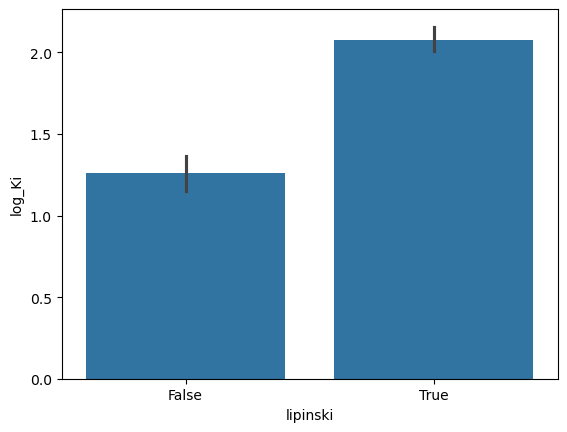

In [96]:
sns.barplot(entire, x="lipinski", y="log_Ki")

In [95]:
entire = entire.dropna(subset=["log_Ki"])
t_test = ttest_ind(
    a=entire.query("lipinski==True")["log_Ki"],
    b=entire.query("lipinski==False")["log_Ki"],
    equal_var=False,
)
print(
    f"T-test Results:\n\t- Statistic: t={t_test.statistic}\n\t- P-value: p={t_test.pvalue:.3e}"
)

T-test Results:
	- Statistic: t=11.849199086399498
	- P-value: p=2.590e-31


In [103]:
# last TODO: metrics overlayed on this: is higher metrics in lipinski?


with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations = pd.DataFrame(citations)
# classified_dois = pd.merge(
#     left=classified_action, right=dois, left_index=True, right_index=True
# )
# classified_citations = pd.merge(
#     left=classified_dois,
#     right=citations,
#     left_on="Article DOI",
#     right_on="doi",
#     how="inner",
# )  # note: around half the mechanisms are lost because don't have publication
# # classified_citations["mechanism"].value_counts()/classified_citations["mechanism"].shape[0] #but proportion remains similar (89%-11%) --> ok for further analysis
# classified_citations.drop(
#     columns=["log_IC50", "log_Ki", "Article DOI", "doi"], inplace=True
# )
citations

doi  citation
0                  10.1038/nbt.1990    1752.0
1                   10.1038/nbt1358    2047.0
2      10.1182/blood-2009-05-222034     495.0
3             10.1093/toxsci/kft176     195.0
4      10.1016/j.ejmech.2019.111825      12.0
...                             ...       ...
40732    10.1016/j.bmcl.2015.02.067      14.0
40733    10.1016/j.bmcl.2007.09.073      28.0
40734  10.1016/j.ejmech.2012.05.006      14.0
40735     10.1016/j.bmc.2007.07.057      55.0
40736             10.1021/np100113e      25.0

[40737 rows x 2 columns]